In [ ]:
# Packages
import json
import zipfile
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import re
import emoji
import unicodedata
import html
import itertools
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib_venn import venn2
import networkx as nx
import gzip
from pyvis.network import Network
import collections
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import random

pd.options.display.max_columns=150
pd.set_option('display.max_colwidth', None)

# Extract data from json files

In [ ]:
# Open the zip file in read mode
with zipfile.ZipFile('datasets/ai4media-sample-v2.zip', 'r') as zip_ref:

    # Get a list of all the file names in the zip file
    file_names = zip_ref.namelist()

    # Empty objects for storage
    data = {
        'id' : [],
        'text' : [],
        # 'raw_text' : [],
        'created_at': [],
        'user_id':[],
        'username':[],
        'followers':[],
        'tweet_count':[],
        'hashtags':[],
        'cashtags':[],
        'mentions':[],
        'context_id':[],
        'context_type':[],
        'context_text':[],
        'context_created_at_time':[],
        'retweet_count':[],
        'reply_count':[],
        'like_count':[],
        'quote_count':[],
        'is_retweet':[],
        'retweet_id':[],
        'topics' : [],
        'origin_file' : [],
        'api': []
    }

    # Iterate over the file names and collect all the unique keys

    # REMOVE THE INDICES LATER
    for file_name in tqdm(file_names[0:5]):

        # Disregards the statistics file
        if file_name != 'statistics.json':

            # Open json file
            with zip_ref.open(file_name, 'r') as f:
                json_data = json.load(f)

                # Iterate over the element inside the json file to get the keys

                # REMOVE THIS LATER
                # count = 0
                for i in json_data:

                    # Use only tweets in English
                    if i["lang"] == 'en':

                        # #REMOVE LATER
                        # #raw text
                        # data['raw_text'].append(i['text'])

                        # User related variables
                        data['user_id'].append(i['user']['id'])

                        # Topics and origin
                        data['topics'].append(i["topics"])
                        data['origin_file'].append(file_name)
                        data['api'].append(i["api"])

                        # Time of the post
                        data['created_at'].append(i["created_at"])

                        # Extract variables according to API v1.1
                        if i['api'] == 'v1':

                            # tweet id
                            data['id'].append(i['id_str'])

                            # text
                            # if i["text"].endswith('…') or i['truncated'] == True:
                            if i['truncated'] == True:
                                data['text'].append(i['extended_tweet']['full_text'])
                            elif 'retweeted_status' in i.keys():
                                if 'extended_tweet' in i['retweeted_status'].keys():
                                    data['text'].append(i['retweeted_status']['extended_tweet']['full_text'])
                                else:
                                    data['text'].append(i['retweeted_status']['text'])
                            else:
                                data['text'].append(i['text'])

                            #retweet info
                            # if bool(re.match(r"RT @[^:\s]+:", i['text'])) or 'retweeted_status_id' in i.keys():
                            if bool(re.match(r"RT @[^:\s]+:", i['text'])) or 'retweeted_status' in i.keys():
                                data['is_retweet'].append(True)
                                if 'retweeted_status' in i.keys():
                                    data['retweet_id'].append(i['retweeted_status']['id_str'])
                                else:
                                    data['retweet_id'].append(None)

                            else:
                                data['is_retweet'].append(False)
                                data['retweet_id'].append(None)

                            #context info (replied to and quoted)
                            context_id = []
                            context_type = []
                            context_text = []
                            context_created_at_time = []
                            # if 'quoted_status_id_str' in i.keys() and i['quoted_status_id_str']!=None and i['quoted_status'] != None and i['quoted_status']['lang'] == 'en':
                            if 'quoted_status' in i.keys() and i['quoted_status'] != None and i['quoted_status']['lang'] == 'en':
                                context_id.append(i['quoted_status']['id_str'])
                                context_created_at_time.append(i['quoted_status']['created_at'])
                                context_type.append('quoted')
                                if i['quoted_status']['truncated'] == True:
                                    context_text.append(i['quoted_status']['extended_tweet']['full_text'])
                                else:
                                    context_text.append(i['quoted_status']['text'])
                            if 'in_reply_to_status_id_str' in i.keys() and i['in_reply_to_status_id_str']!=None:
                                context_id.append(i['in_reply_to_status_id_str'])
                                context_type.append('replied_to')
                                context_text.append(None)
                                context_created_at_time.append(None)
                            data['context_id'].append(context_id)
                            data['context_created_at_time'].append(context_created_at_time)
                            data['context_type'].append(context_type)
                            data['context_text'].append(context_text)

                            #user info
                            data['username'].append(i['user']['screen_name'])
                            data['followers'].append(i['user']['followers_count'])
                            data['tweet_count'].append(i['user']['statuses_count'])

                            #hashtags, mentions and cashtags
                            if 'entities' in i.keys() and 'hashtags' in i['entities'].keys():
                                data['hashtags'].append([j['text'] for j in i['entities']['hashtags']])
                            else:
                                data['hashtags'].append([])

                            if 'entities' in i.keys() and 'symbols' in i['entities'].keys():
                                data['cashtags'].append([j['text'] for j in i['entities']['symbols']])
                            else:
                                data['cashtags'].append([])

                            if 'entities' in i.keys() and 'user_mentions' in i['entities'].keys():
                                data['mentions'].append([j['screen_name'] for j in i['entities']['user_mentions']])
                            else:
                                data['mentions'].append([])

                            #retweets, reply, quotes and liked count
                            data['retweet_count'].append(i['retweet_count'])
                            data['reply_count'].append(i['reply_count'])
                            data['like_count'].append(i['favorite_count'])
                            data['quote_count'].append(i['quote_count'])


                        # Extract variables according to API v2
                        elif i['api'] == 'v2':

                            # tweet id
                            data['id'].append(i['id'])

                            # text
                            if 'referenced_tweets' in i.keys() and 'retweeted' in [j['type'] for j in i['referenced_tweets']]:
                                for j in i['referenced_tweets']:
                                    if j['type'] == 'retweeted':
                                        data['text'].append(j['tweet']['text'])
                            else:
                                data['text'].append(i["text"])

                            #retweet info
                            if bool(re.match(r"RT @[^:\s]+:", i['text'])) or 'referenced_tweets' in i.keys() and 'retweeted' in [j['type'] for j in i['referenced_tweets']]:
                                data['is_retweet'].append(True)
                                if 'referenced_tweets' in i.keys() and 'retweeted' in [j['type'] for j in i['referenced_tweets']]:
                                    data['retweet_id'].append([j['id'] for j in i['referenced_tweets'] if j['type'] == 'retweeted'][0])
                                else:
                                    data['retweet_id'].append(None)
                            else:
                                data['is_retweet'].append(False)
                                data['retweet_id'].append(None)

                            #context info (replied to and quoted)
                            context_id = []
                            context_created_at_time = []
                            context_type = []
                            context_text = []
                            if 'referenced_tweets' in i.keys() and i['referenced_tweets'] != None:
                                for j in i['referenced_tweets']:
                                    if j['type'] != 'retweeted':
                                        context_id.append(j['id'])
                                        context_type.append(j['type'])
                                        if 'tweet' in j.keys() and j['tweet'] != None and j['tweet']['lang'] == 'en':
                                            context_text.append(j['tweet']['text'])
                                            context_created_at_time.append(j['tweet']['created_at'])
                                        else:
                                            context_text.append(None)
                                            context_created_at_time.append(None)
                            data['context_id'].append(context_id)
                            data['context_created_at_time'].append(context_created_at_time)
                            data['context_type'].append(context_type)
                            data['context_text'].append(context_text)

                            #user info
                            data['username'].append(i['user']['username'])
                            data['followers'].append(i['user']['public_metrics']['followers_count'])
                            data['tweet_count'].append(i['user']['public_metrics']['tweet_count'])

                            #hashtags, mentions and cashtags
                            if 'entities' in i.keys() and 'hashtags' in i['entities'].keys():
                                data['hashtags'].append([j['tag'] for j in i['entities']['hashtags']])
                            else:
                                data['hashtags'].append([])

                            if 'entities' in i.keys() and 'cashtags' in i['entities'].keys():
                                data['cashtags'].append([j['tag'] for j in i['entities']['cashtags']])
                            else:
                                data['cashtags'].append([])

                            if 'entities' in i.keys() and 'mentions' in i['entities'].keys():
                                data['mentions'].append([j['username'] for j in i['entities']['mentions']])
                            else:
                                data['mentions'].append([])

                            #retweets, reply, quotes and liked count
                            data['retweet_count'].append(i['public_metrics']['retweet_count'])
                            data['reply_count'].append(i['public_metrics']['reply_count'])
                            data['like_count'].append(i['public_metrics']['like_count'])
                            data['quote_count'].append(i['public_metrics']['quote_count'])


                    # REMOVE THIS LATER
                    # count += 1

                # REMOVE THIS LATER
                # Temporary break
                # if len(data['text'])>50:
                #     break




In [17]:
# create pandas df
df_raw = pd.DataFrame.from_dict(data)

# check variable type (object means string)
print(df_raw.dtypes)

# see dataset
df_raw

id                         object
text                       object
created_at                 object
user_id                    object
username                   object
followers                   int64
tweet_count                 int64
hashtags                   object
cashtags                   object
mentions                   object
context_id                 object
context_type               object
context_text               object
context_created_at_time    object
retweet_count               int64
reply_count                 int64
like_count                  int64
quote_count                 int64
is_retweet                   bool
retweet_id                 object
topics                     object
origin_file                object
api                        object
dtype: object


,id,text,created_at,user_id,username,followers,tweet_count,hashtags,cashtags,mentions,context_id,context_type,context_text,context_created_at_time,retweet_count,reply_count,like_count,quote_count,is_retweet,retweet_id,topics,origin_file,api
0,1242793775254175746,Hydroxychloroquine (malaria drug) and azithrom...,2020-03-25T12:41:40.000Z,152119847,sneezylafamilia,595,26462,[],[],[DrNasimC],[],[],[],[],5,0,0,0,True,1242477745692688384,"[2041p1, 2002p1, 2001p1]",2002p1-tweets-1.json,v2
1,1243522875728019458,@hunzvi4 @LynneStactia @DuchessTalitha @AmCham...,Fri Mar 27 12:58:51 +0000 2020,54491497,fibolin,1101,38368,[],[],"[lawmasaka, hunzvi4, LynneStactia, DuchessTali...",[],[],[],[],0,0,0,0,True,1243492040136146944,"[2041p1, 2002p1, 2001p1]",2002p1-tweets-1.json,v1
2,1242318993937104899,An Arizona man died and his wife was hospitali...,2020-03-24T05:15:03.000Z,807095,nytimes,50225189,442395,[],[],[],[],[],[],[],2467,885,4973,534,False,None,"[2041p1, 2117p1, 2129p1, 2002p1, 2044p1, 2054p...",2002p1-tweets-1.json,v2
3,1242337451764572161,@galloy_tammie @murphtoday @gtconway3d @realDo...,2020-03-24T06:28:24.000Z,787736606195277824,LJT_is_me,6188,225120,[],[],"[galloy_tammie, murphtoday, gtconway3d, realDo...",[1242335623899500546],[replied_to],[None],[None],9,3,7,1,False,None,"[2041p1, 2002p1, 2001p1]",2002p1-tweets-1.json,v2
4,1242477745692688384,Hydroxychloroquine (malaria drug) and azithrom...,2020-03-24T15:45:53.000Z,1241236413347233792,DrNasimC,193,288,"[coronavirus, StayHome]",[],[],[1242318993937104899],[quoted],[An Arizona man died and his wife was hospital...,[2020-03-24T05:15:03.000Z],5,0,10,0,False,None,"[2041p1, 2002p1, 2001p1]",2002p1-tweets-1.json,v2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057289,1329306728769282050,Exactly https://t.co/NiyK0XG7S1,2020-11-19T06:13:16.000Z,84480652,JwarrenC0,868,32276,[],[],[],[1328789051298689027],[quoted],[Great news! \n- Pfizer vaccine 90% effective\...,[2020-11-17T19:56:12.000Z],0,0,0,0,False,None,"[2081p2, 2080p2]",2081p2-tweets-1.json,v2
1057290,1329306782255042560,Temperatures at which vaccines for COVID-19 ar...,2020-11-19T06:13:28.000Z,637082658,ra_ban_i,271,22012,[],[],[BT_India],[],[],[],[],9,0,0,0,True,1328680054289666049,"[2081p2, 2080p2]",2081p2-tweets-1.json,v2
1057291,1329306882180222978,"Ladies: Prior to tonight, you were asked to pr...",2020-11-19T06:13:52.000Z,1211472774729891841,PrinConsuela1,3,361,[],[],[joeynolfi],[],[],[],[],4291,0,0,0,True,1329074942030143488,"[2081p2, 2080p2]",2081p2-tweets-1.json,v2
1057292,1329306977655160833,Bad news!\n- Pfizer vaccine 0 deaths\n- Modern...,2020-11-19T06:14:15.000Z,95943406,DrMCGregoire,1179,5221,[],[],[DrScottHadland],[],[],[],[],158,0,0,0,True,1329120402132643841,"[2081p2, 2080p2]",2081p2-tweets-1.json,v2


In [2]:
# Save pandas dataframe
# pickle.dump(df_raw, open("results/df_raw.pkl", "wb"))
# Load pandas dataframe
df_raw = pickle.load(open("results/df_raw.pkl", "rb"))

# Variables modification and creation

In [3]:
# Text cleaning functions

def remove_diacritics(text):
    nfkd_form = unicodedata.normalize('NFKD', text)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

def clean_unicodes(text):
    # Keep all regional indicator symbols
    regional_indicator_symbols = [char for char in text if unicodedata.name(char, "").startswith("REGIONAL INDICATOR")]
    # Remove all non-ASCII characters except emojis and regional indicator symbols
    cleaned_text = ''.join([char for char in text if char.isascii() or emoji.emoji_count(char) > 0 or char in regional_indicator_symbols])
    return cleaned_text

def custom_clean_text(dataframe, text_column_name):
    # Remove any retweet structure
    dataframe[text_column_name] = dataframe[text_column_name].str.replace(r"RT @[^:\s]+:", '', regex = True)
    # Remove any URLs
    dataframe[text_column_name] = dataframe[text_column_name].str.replace(r'https?://\S+', '', regex = True)
    # Replace particular escape sequences with a space
    dataframe[text_column_name] = dataframe[text_column_name].str.replace(r'\xa0|\x9d|\xb6|\\|\t|\n|\r|\f', ' ', regex = True)
    # Replace HTML entities with their corresponding ASCII characters
    dataframe[text_column_name] = dataframe[text_column_name].apply(html.unescape)
    # Replace multiple spaces with a single space
    dataframe[text_column_name] = dataframe[text_column_name].str.replace(r'\s+', ' ', regex=True)
    # Remove empty spaces at the end of the tweet
    dataframe[text_column_name] = dataframe[text_column_name].str.replace(r'\s+$', '', regex=True)
    # Replace specified Unicode characters with ASCII equivalents since these are the most common ones
    dataframe[text_column_name] = dataframe[text_column_name].str.replace('’', "'")
    dataframe[text_column_name] = dataframe[text_column_name].str.replace('‘', "'")
    dataframe[text_column_name] = dataframe[text_column_name].str.replace('“', '"')
    dataframe[text_column_name] = dataframe[text_column_name].str.replace('”', '"')
    # Remove diacritics
    dataframe[text_column_name] = dataframe[text_column_name].apply(remove_diacritics)
    # Clean unicodes
    dataframe[text_column_name] = dataframe[text_column_name].apply(clean_unicodes)

    return dataframe[text_column_name]

In [4]:
df = df_raw

# Create a variable to save the original text
df['original_text'] = df['text']

# Text cleanning
df['text'] = custom_clean_text(dataframe = df, text_column_name = 'text')

# Convert to pandas datetime
df['created_at'] = pd.to_datetime(df['created_at'], format='mixed')

In [5]:
# Transform variables that contain lists into tuples for easier processing
for column in df.columns:
    if df[column].apply(type).eq(list).all():
        df[column] = df[column].apply(tuple)

# Remove duplicates in tweet IDs

We need to remove duplicates of tweet IDs, because the following steps will include some joins based on the tweet ID, 
As we see in the results below, duplicates in the ID happen because the same tweet exists in two or more json files. 
That's why we see that for the same ID, all other variables are the same, except for the ```origin_file``` and sometimes the ```topics```. 
The ```topics``` variable can present variations because it is closely related to the ```origin file``` variable.

We group by all variables except ```origin_file``` and ```topics``` and aggregate those. 

## Understanding the ID duplicates

In [154]:
# Get all rows with a duplicate tweeter ID.
df_duplicate_ids = df[df['id'].duplicated(keep = False)]
df_duplicate_ids

,id,text,created_at,user_id,username,followers,tweet_count,hashtags,cashtags,mentions,context_id,context_type,context_text,context_created_at_time,retweet_count,reply_count,like_count,quote_count,is_retweet,retweet_id,topics,origin_file,api,original_text
26,1246518325926080513,"1/2 Absent major technological breakthrough before fall (effective drugs) American life won't normalize, economic activity won't snap back. Which makes it frustrating why policy makers seem oddly unfocused about getting the kinds of therapeutics that should be obtainable.",2020-04-04 19:21:42+00:00,40156330,ScottGottliebMD,488731,19960,(),(),(),(),(),(),(),2455,262,9089,153,False,None,"(2007p1, 2002p1, 2126p1, 2054p1, 2046p1, 2105p1, 2106p1, 2001p1, 2110p1, 2103p1)",2002p1-tweets-1.json,v2,"1/2 Absent major technological breakthrough before fall (effective drugs) American life won’t normalize, economic activity won’t snap back. Which makes it frustrating why policy makers seem oddly unfocused about getting the kinds of therapeutics that should be obtainable."
31,1243496858095411200,"Over the last 24 hours I have developed mild symptoms and tested positive for coronavirus. I am now self-isolating, but I will continue to lead the government's response via video-conference as we fight this virus. Together we will beat this. #StayHomeSaveLives",2020-03-27 11:15:28+00:00,3131144855,BorisJohnson,3585016,4782,"(StayHomeSaveLives,)",(),(),(),(),(),(),116867,53206,348058,45701,False,None,"(2050p1, 2061p1, 2047p1, 2057p1, 2130p1, 2132p1, 2117p1, 2062p1, 2063p1, 2060p1, 2002p1, 2126p1, 2054p1, 2101p1, 2123p1, 2046p1, 2105p1, 2102p1, 2121p1, 2040p1, 2122p1, 2106p1, 2121p2, 2040p2, 2001p1, 2110p1, 2110p2, 2103p1)",2002p1-tweets-1.json,v2,"Over the last 24 hours I have developed mild symptoms and tested positive for coronavirus.\n\nI am now self-isolating, but I will continue to lead the government’s response via video-conference as we fight this virus.\n\nTogether we will beat this. #StayHomeSaveLives https://t.co/9Te6aFP0Ri"
33,1272976158804434944,"Going to REPEAT, REPEAT, REPEAT: #COVID19 is still here. Wear a face covering. Wash your hands. Practice physical distancing. Be smart.",2020-06-16 19:35:41+00:00,11347122,GavinNewsom,1961860,14778,"(COVID19,)",(),(),(),(),(),(),20776,2605,77974,1021,False,None,"(2050p1, 2051p1, 2117p1, 2062p1, 2002p1, 2054p1, 2123p1, 2046p1, 2121p1, 2040p1, 2122p1, 2106p1, 2110p1)",2002p1-tweets-1.json,v2,"Going to REPEAT, REPEAT, REPEAT: #COVID19 is still here.\n\nWear a face covering. Wash your hands. Practice physical distancing. Be smart."
34,1283037924586594306,"President @realDonaldTrump is taking historic ACTION to combat coronavirus: ✅ Surging personnel to AZ, TX, CA, FL ✅ Surging Remdesivir ✅ Surging test supplies reducing turnaround time ✅ Dr. Birx to visit LA, MS, AL, GA, SC ✅ 19 HHS teams sent to metros; 8 more this week",2020-07-14 13:57:33+00:00,818927131883356161,PressSec45,5972191,4316,(),(),"(realDonaldTrump,)",(),(),(),(),1581,3778,7900,364,False,None,"(2050p1, 2057p1, 2131p1, 2062p1, 2063p1, 2060p1, 2002p1, 2054p1, 2046p1, 2121p1, 2040p1, 2106p1, 2001p1, 2110p1)",2002p1-tweets-1.json,v2,"President @realDonaldTrump is taking historic ACTION to combat coronavirus:\n\n✅ Surging personnel to AZ, TX, CA, FL\n\n✅ Surging Remdesivir\n\n✅ Surging test supplies reducing turnaround time\n\n✅ Dr. Birx to visit LA, MS, AL, GA, SC\n\n✅ 19 HHS teams sent to metros; 8 more this week"
37,1283918085288652800,President Obama and I left a playbook for President Trump on how to fight pandemics. He flat-out ignored it. And we're all paying the price every day.,2020-07-17 00:15:00+00:00,939091,JoeBiden,30915594,7472,(),(),(),(),(),(),(),56425,22276,303589,5226,False,None,"(2128p1, 2113p1, 2129p1, 2060p1, 2002p1, 2054p1, 2046p1, 2102p1, 2121p1, 2040p1, 2122p1, 2106p1, 2001p1, 2110p1)",2002p1-tweets-1.json,v2,President Obama and I left a playbook for President Trump on how to fight pandemics. He flat-out ignored it. And we're all paying the 

In [24]:
# IDs with duplicates
duplicated_ids = np.unique(df_duplicate_ids['id'])

# For each ID get the columns that contain differences
mismatch_columns = []
for id in tqdm(duplicated_ids):
    data_ = df[df['id'] == id]
    mismatch_columns.append(data_.columns[data_.nunique() > 1])

  0%|          | 0/7710 [00:00<?, ?it/s]

100%|██████████| 7710/7710 [1:13:51<00:00,  1.74it/s]


In [25]:
# Save results
# pickle.dump(mismatch_columns, open("results/mismatch_columns.pkl", "wb"))
# Load results
mismatch_columns = pickle.load(open("results/mismatch_columns.pkl", "rb"))

In [26]:
# Get which columns present differences when having the same ID
set(tuple(i.tolist()) for i in mismatch_columns)

{('origin_file',), ('topics', 'origin_file')}

## Remove the ID duplicates

In [6]:
# List of variables to group by (all variables except origin_file and topics)
group_by_columns = [i for i in df.columns.tolist() if i not in ['origin_file','topics']]

# aggregation method for origin_file
def custom_agg_origin(series):
    return tuple(set(series))

# aggregation method for topics
def custom_agg_topics(series):
    unique_elements = set(item for tup in series for item in tup)
    return tuple(sorted(unique_elements))

# remove duplicate ids, keep all unique elements for topics and origin_file for each id
df = df.groupby(group_by_columns, dropna = False).agg({'origin_file': custom_agg_origin, 'topics': custom_agg_topics}).reset_index()

df

,id,text,created_at,user_id,username,followers,tweet_count,hashtags,cashtags,mentions,context_id,context_type,context_text,context_created_at_time,retweet_count,reply_count,like_count,quote_count,is_retweet,retweet_id,api,original_text,origin_file,topics
0,1000009263463333888,"Suicide rates are on the rise, particularly in rural, red counties as a result of easy access to guns, drug abuse and abysmal socioeconomic conditions. Don't ever let the @GOP invoke ""mental health"" when statistics prove they don't really give a damn.",2018-05-25 13:42:42+00:00,16582131,docrocktex26,125302,564025,(),(),"(GOP,)","(1000006497735241728,)","(replied_to,)","(Mapping the rising tide of suicide deaths across the United States https://t.co/nUXnu4APup,)","(2018-05-25T13:31:42.000Z,)",688,29,1238,34,False,NaN,v2,"Suicide rates are on the rise, particularly in rural, red counties as a result of easy access to guns, drug abuse and abysmal socioeconomic conditions. Don’t ever let the @GOP invoke “mental health” when statistics prove they don’t really give a damn. https://t.co/nUXnu4je5P https://t.co/lcVLLtFEVd","(2046p1-tweets-1.json,)","(2001p1, 2040p1, 2046p1, 2054p1, 2062p1, 2102p1, 2103p1, 2106p1, 2110p1, 2121p1, 2122p1, 2123p1)"
1,1000031824830173184,"In other words, elections have consequences. The Republican base is getting exactly what it asked for: rage, resentment, ignorance, financial strife, a broken safety net, guns, drugs and segregation, all of which are resulting in ""untimely"" deaths. It's actual political suicide.",2018-05-25 15:12:21+00:00,16582131,docrocktex26,125306,563857,(),(),(),"(1000028737973481472,)","(replied_to,)","(The physician/scientist in me sees the disparity and wants to search for a helpful solution for these people, but the PJ in me is like you broke it you bought it, teabag. https://t.co/KqxNq0UjFO,)","(2018-05-25T15:00:05.000Z,)",476,24,1147,25,False,NaN,v2,"In other words, elections have consequences. The Republican base is getting exactly what it asked for: rage, resentment, ignorance, financial strife, a broken safety net, guns, drugs and segregation, all of which are resulting in “untimely” deaths. It’s actual political suicide.","(2046p1-tweets-1.json,)","(2001p1, 2040p1, 2044p1, 2046p1, 2051p1, 2054p1, 2062p1, 2100p1, 2101p1, 2102p1, 2103p1, 2106p1, 2110p1, 2121p1, 2122p1, 2123p1, 2126p1)"
2,1000047225395859456,"Essentially what they've done is segregated themselves into rural/suburban communities full of fearful, paranoid, politically and religiously propagandized people who are self medicating with drugs, guns and fake news then turning to violence/murder/suicide as a last resort.",2018-05-25 16:13:33+00:00,16582131,docrocktex26,125302,564025,(),(),(),"(1000045525671055360,)","(replied_to,)","(150+ years since the Civil War and 50+ years since the Civil Rights Movement, all that Jim Crow/institutionalized racism/apartheid/MAGA has done for White America is this: https://t.co/Z28Q12j8r8,)","(2018-05-25T16:06:47.000Z,)",252,21,719,21,False,NaN,v2,"Essentially what they’ve done is segregated themselves into rural/suburban communities full of fearful, paranoid, politically and religiously propagandized people who are self medicating with drugs, guns and fake news then turning to violence/murder/suicide as a last resort.","(2046p1-tweets-1.json,)","(2001p1, 2040p1, 2046p1, 2054p1, 2062p1, 2102p1, 2103p1, 2106p1, 2110p1, 2121p1, 2122p1, 2123p1)"
3,1000602698767482880,"My interview with #LeilaniEstates resident Victor Hoapili, whose front yard is now a massive lava lake.. #Kilauea #volcano #prayforPuna @StarAdvertiser",2018-05-27 05:00:48+00:00,156465965,kconsillio,1698,2497,"(LeilaniEstates, Kilauea, volcano, prayforPuna)",(),"(StarAdvertiser,)",(),(),(),(),82,24,156,16,False,NaN,v2,"My interview with #LeilaniEstates resident Victor Hoapili, whose front yard is now a massive lava lake.. #Kilauea #volcano #prayforPuna @StarAdvertiser https://t.co/VQRq3FSfhC","(2013p2-tweets-1.json,)","(2013p2,)"
4,1003580907

In [7]:
# Check for rows with duplicates in the tweeter ID, now there are no duplicates
df_duplicate_ids = df[df['id'].duplicated(keep = False)]
df_duplicate_ids

,id,text,created_at,user_id,username,followers,tweet_count,hashtags,cashtags,mentions,context_id,context_type,context_text,context_created_at_time,retweet_count,reply_count,like_count,quote_count,is_retweet,retweet_id,api,original_text,origin_file,topics


# Tweet relationships' tables

In this section we create 2 tables that describe the relationships between tweets. 

1. ```df_relationships``` includes the type of relationship (replied to, quoted, or nothing) between tweets. This tables has both the id of the tweets, and the ```new_id``` which was created to identify tweets with the same text. That is, several ```id```s can be mapped to one ```new_id```. The ```new_id``` is the unique identifier for text.  
2. ```df_relationships_no_duplicates``` contains similar information to the previous table but it doesn't include the ```id``` level. Therefore is removes duplicates. 

Here is a toy example of the differences between the 2 tables:

```df_relationships```

|id|new_id|text|context_type|context_id|new_context_id|context_text|
|--|------|----|------------|----------|--------------|------------|
|101|1|Now I want coffee|replied_to|103|2|Best coffee ever| 
|102|1|Now I want coffee|Na|Na|Na|Na| 
|103|2|Best coffee ever|Na|Na|Na|Na| 
|103|2|Best coffee ever|replied_to|104|3|New pumpkin spice latte!!!| 
|103|2|Best coffee ever|replied_to|105|3|New pumpkin spice latte!!!| 
|104|3|New pumpkin spice latte!!!|Na|Na|Na|Na|
|105|3|New pumpkin spice latte!!!|Na|Na|Na|Na| 
|106|3|New pumpkin spice latte!!!|Na|Na|Na|Na| 

```df_relationships_no_duplicates```

|new_id|text|context_type|new_context_id|context_text|
|------|----|------------|--------------|------------|
|1|Now I want coffee|replied_to|2|Best coffee ever| 
|1|Now I want coffee|Na|Na|Na| 
|2|Best coffee ever|Na|Na|Na| 
|2|Best coffee ever|replied_to|3|New pumpkin spice latte!!!| 
|3|New pumpkin spice latte!!!|Na|Na|Na| 

## df_relationships

In [8]:
# Transform each element of a list to a row, replicating the other values
df_relationships = df[['id', 'text', 'created_at', 'context_id', 'context_type', 'context_text', 'context_created_at_time']] \
    .explode(['context_id', 'context_type', 'context_text', 'context_created_at_time']) \
    .reset_index(drop=True)

# Fill NaNs and Nones in the context_text with and empty string
df_relationships['context_text'] = df_relationships['context_text'].fillna('')
# Clean text
df_relationships['context_text'] = custom_clean_text(dataframe = df_relationships, text_column_name = 'context_text')
# Empty strings back to None
df_relationships['context_text'].replace('', None, inplace = True)

# Convert to pandas datetime
df_relationships['context_created_at_time'] = pd.to_datetime(df_relationships['context_created_at_time'], format='mixed')

df_relationships

,id,text,created_at,context_id,context_type,context_text,context_created_at_time
0,1000009263463333888,"Suicide rates are on the rise, particularly in rural, red counties as a result of easy access to guns, drug abuse and abysmal socioeconomic conditions. Don't ever let the @GOP invoke ""mental health"" when statistics prove they don't really give a damn.",2018-05-25 13:42:42+00:00,1000006497735241728,replied_to,Mapping the rising tide of suicide deaths across the United States,2018-05-25 13:31:42+00:00
1,1000031824830173184,"In other words, elections have consequences. The Republican base is getting exactly what it asked for: rage, resentment, ignorance, financial strife, a broken safety net, guns, drugs and segregation, all of which are resulting in ""untimely"" deaths. It's actual political suicide.",2018-05-25 15:12:21+00:00,1000028737973481472,replied_to,"The physician/scientist in me sees the disparity and wants to search for a helpful solution for these people, but the PJ in me is like you broke it you bought it, teabag.",2018-05-25 15:00:05+00:00
2,1000047225395859456,"Essentially what they've done is segregated themselves into rural/suburban communities full of fearful, paranoid, politically and religiously propagandized people who are self medicating with drugs, guns and fake news then turning to violence/murder/suicide as a last resort.",2018-05-25 16:13:33+00:00,1000045525671055360,replied_to,"150+ years since the Civil War and 50+ years since the Civil Rights Movement, all that Jim Crow/institutionalized racism/apartheid/MAGA has done for White America is this:",2018-05-25 16:06:47+00:00
3,1000602698767482880,"My interview with #LeilaniEstates resident Victor Hoapili, whose front yard is now a massive lava lake.. #Kilauea #volcano #prayforPuna @StarAdvertiser",2018-05-27 05:00:48+00:00,NaN,NaN,None,NaT
4,1003580907532451842,"@khamenei_ir I'm not officially posting :), but given the number of appalling comments in reply, I wanted to say that it is good to see the head of the Philosophers' republic, Ayatollah Khamanei, state the correct moral position. We can never accept the open, beastly colonialism of a people.",2018-06-04 10:15:08+00:00,1003332853525110784,replied_to,None,NaT
...,...,...,...,...,...,...,...
1073462,994272740654825472,"@anblanx @NBCInvestigates And in Novartis' statement, they're expressly trying to deflect any blame away from the new CEO (Narasimhan), that met with Trump in Davos:",2018-05-09 17:47:48+00:00,994272184821469187,replied_to,@anblanx @NBCInvestigates New Novartis CEO started the month the Cohen contract ended 2/18 (though it was announced earlier):,2018-05-09 17:45:36+00:00
1073463,994898467762909184,"Germans eat a variety of minced meats including pork in sausages, and name them usually with -wurst at the end: Bratwurst, Bockwurst, liverwurst... and eat them with dry bread & the strongest herb, marjoram. The human subconscious knows something... Americans place them in salad",2018-05-11 11:14:13+00:00,994740059084640257,replied_to,None,NaT
1073464,995548360173015041,I met @HillaryClinton earlier in the week. I thanked her. She's made things just that little bit easier for our daughters and our granddaughters. As has every strong woman across our state.,2018-05-13 06:16:40+00:00,NaN,NaN,None,NaT
1073465,995557007544512512,"As for Nawaz Sharif he has been quite happy sending sometimes quite innocent men to the gallows through the anti-terrorism courts (ATC or military tribunals). All to appease western pressure. But those courts, no doubt, will prove useful, and Nawaz Sharif will find out why...",2018-05-13 06:51:01+00:00,995556659966685184,replied_to,"So, Sa'ad Hariri got a humiliation, from the people of Lebanon. How nice. When does he plan on resigning?",2018-05-13 06:49:38+00:00


Try to complete information for context tweets that only had id information but not the text. 

In [9]:
# Left join df_relationships with df.
df_relationships = df_relationships.merge(df[['id', 'text', 'created_at']], left_on='context_id', right_on='id', how='left', suffixes=('','_y'))

# Some numbers to check the improvement
n_context_id = len(df_relationships.loc[df_relationships['context_id'].notna()])
n_context_text_before = len(df_relationships.loc[df_relationships['context_text'].notna()])
n_context_created_at_before = len(df_relationships.loc[df_relationships['context_created_at_time'].notna()])

# Complete information when available
df_relationships['context_text'] = df_relationships.context_text.combine_first(df_relationships.text_y)
df_relationships['context_created_at_time'] = df_relationships.context_created_at_time.combine_first(df_relationships.created_at_y)

# Some numbers to check the improvement
n_context_text_after = len(df_relationships.loc[df_relationships['context_text'].notna()])
n_context_created_at_after = len(df_relationships.loc[df_relationships['context_created_at_time'].notna()])

print('% rows with "context" text and "created at" information out of all rows that have some context_id')
print('Before left join')
print('% rows with context text info', n_context_text_before/n_context_id * 100)
print('% rows with context created at info', n_context_created_at_before/n_context_id * 100)
print('After left join')
print('% rows with context text info', n_context_text_after/n_context_id * 100)
print('% rows with context created at info', n_context_created_at_after/n_context_id * 100)

# Remove columns that we don't need anymore
df_relationships = df_relationships[df_relationships.columns[~df_relationships.columns.str.endswith('_y')]]

% rows with "context" text and "created at" information out of all rows that have some context_id
Before left join
% rows with context text info 87.46442515758773
% rows with context created at info 87.46442515758773
After left join
% rows with context text info 92.40756421112052
% rows with context created at info 92.40756421112052


Eventhough there is an improvement in the number of examples with ```context_text``` info, there are still instances with some context information (e.g. not NaN values in ```context_type```, ```context_id``` or ```context_created_at_time```) but no ```context_text```. For instance, see the examples below. In this cases, given that there is no ```context_text``` information, all the other context related variables should be NaN. Otherwise, they will create problems in subsequent merging processes. 

In [10]:
# Rows without context_text but with other context information
bool_specific_instances = (df_relationships['context_type'].notna() | df_relationships['context_id'].notna() | df_relationships['context_created_at_time'].notna()) & df_relationships['context_text'].isna()
df_relationships[bool_specific_instances]

,id,text,created_at,context_id,context_type,context_text,context_created_at_time
4,1003580907532451842,"@khamenei_ir I'm not officially posting :), but given the number of appalling comments in reply, I wanted to say that it is good to see the head of the Philosophers' republic, Ayatollah Khamanei, state the correct moral position. We can never accept the open, beastly colonialism of a people.",2018-06-04 10:15:08+00:00,1003332853525110784,replied_to,NaN,NaT
5,1003594173503729664,"@khamenei_ir Here is the text of the email: 'Dear Sir, I saw the coverage of your 'stuff' site regarding the diplomat's comments on the 'cancer' of Israel at a mosque. I was astonished and dismayed by your tone, which confirms the worst opinions of westerners in the middle east and world...",2018-06-04 11:07:51+00:00,1003587847654342658,replied_to,NaN,NaT
6,1003597466237890560,@khamenei_ir ... Kindly do everyone a favour and place a notice on your stuffed site and any others you may have to warn any Middle Easterners who have the misfortune to stumble across it on the sadly 'shared' global platform of the internet that you are pro-zionist and pro-politicide.,2018-06-04 11:20:56+00:00,1003596142758776834,replied_to,NaN,NaT
23,1017600327506415616,"A fat American rolled into a doctor's surgery one day, and sat down in front of the plump doctor looking at his bmi chart. 'Well, doc?' he asked, genially. 'Why have you called me in?' 'Oh, nothing to worry about. I have to just do a routine check. Erm, now, I notice the bmi...",2018-07-13 02:43:18+00:00,1017599956486680577,replied_to,NaN,NaT
33,1022591790644228096,"@doublecupdes I'm not a mum, but I got a booster DPT as well as quad-flu shot on the same day on the same arm in 2015. Rest well,don't lift things you'd normally manage to lift using the arm.Put a heat pack on it; preferably gel-it's pliable &cushions up.If you sleep on the side,avoid this arm",2018-07-26 21:17:36+00:00,1022563917053263874,replied_to,NaN,NaT
...,...,...,...,...,...,...,...
1073453,976943601166012416,"4/ It was Alexander Downer in London, closely associated with Hakluyt (now Holdingham Group Ltd) a private MI6 outfit, that met with Papadopulos. The FBI used AD's statement about Misfud to open the FISA interception warrants against the Trump camp.",2018-03-22 22:07:59+00:00,976943598049558528,replied_to,NaN,NaT
1073455,979777907194257409,Congrats to my friend @DrMennoSmit @LSTMnews @KEMRI_Kenya This excellent study published in @TheLancetInfDis demonstrates that #ivermectin may offer a new tool to eliminate #malaria,2018-03-30 17:50:31+00:00,978879762956464128,quoted,NaN,NaT
1073456,985681363423592449,"@BryanP1977 @khamenei_ir I am The Kamboja. I'm not shi'a, moron. I am Sunni. However since you're curiouser than a cat yourself, I'll tell you that most of the clan in Hamadan is a mix of Zoroastrian and Shia. I have instructed them all to become Sunni now the clan is making up.",2018-04-16 00:48:44+00:00,985671696068771840,replied_to,NaN,NaT
1073458,992112778415628288,"One day, Archbishop Tutu decided to visit America. However, no matter where he went or what he said, each time he got the same response. 'Tutu? Tutu? He's not wearing a tutu.' The day before, the Archbishop had criticised Israel.",2018-05-03 18:44:53+00:00,992109789898596352,replied_to,NaN,NaT


In [11]:
# Convert context variables to NaN when context_text is not available
df_relationships.loc[df_relationships['context_text'].isna() , 'context_id'] = np.nan
df_relationships.loc[df_relationships['context_text'].isna() , 'context_created_at_time'] = np.nan
df_relationships.loc[df_relationships['context_text'].isna() , 'context_type'] = np.nan

# Check that there are no more instances of the problem
print(sum((df_relationships['context_type'].notna() | df_relationships['context_id'].notna() | df_relationships['context_created_at_time'].notna()) & df_relationships['context_text'].isna()))

# Remove duplicates created after changes
df_relationships = df_relationships.drop_duplicates()

0


Note that in some cases the context text is identical to the text of the tweet. That is, that reply or quote behaves like a retweet. Therefore, in this cases the context information should be removed.

In [12]:
# Examples of tweet with text equals to context text.
print('Number of rows with the issue:', len(df_relationships[df_relationships['text'] == df_relationships['context_text']]))
df_relationships[df_relationships['text'] == df_relationships['context_text']]

Number of rows with the issue: 248


,id,text,created_at,context_id,context_type,context_text,context_created_at_time
513,1237399342828355584,Reminder: It will get dumber.,2020-03-10 15:26:07+00:00,1236899405158113280,replied_to,Reminder: It will get dumber.,2020-03-09 06:19:33+00:00
7863,1243353895956557824,@tommyHotpockets Below tweet by Coronavirus-follower mlipsitch reached the 94.1 percentile in under 8 minutes. #COVID19 #COVID19 (This is an algorithmic tweet thread. Mute this thread or #CoronaVirusExpert if uninterested),2020-03-27 01:47:23+00:00,1243353663361482754,replied_to,@tommyHotpockets Below tweet by Coronavirus-follower mlipsitch reached the 94.1 percentile in under 8 minutes. #COVID19 #COVID19 (This is an algorithmic tweet thread. Mute this thread or #CoronaVirusExpert if uninterested),2020-03-27 01:46:28+00:00
8444,1243439646190731266,@tommyHotpockets Below retweet of mlipsitch by Coronavirus-follower InfectiousDz reached the 100.0 percentile in under 27 minutes. #COVID19 #COVID19 (This is an algorithmic retweet thread. Mute this thread or #CoronaVirusExpert if uninterested),2020-03-27 07:28:08+00:00,1243439644903116801,replied_to,@tommyHotpockets Below retweet of mlipsitch by Coronavirus-follower InfectiousDz reached the 100.0 percentile in under 27 minutes. #COVID19 #COVID19 (This is an algorithmic retweet thread. Mute this thread or #CoronaVirusExpert if uninterested),2020-03-27 07:28:07+00:00
13616,1243949723762987011,"Dr. Donald Trump: ""I like this stuff. I really get it. I had a great, super-genius uncle. People are really surprised I understand this stuff. Every one of these doctors said 'How do you know so much about this ?' Maybe I have a natural ability"" Also Trump:",2020-03-28 17:15:00+00:00,1243948496950091778,replied_to,"Dr. Donald Trump: ""I like this stuff. I really get it. I had a great, super-genius uncle. People are really surprised I understand this stuff. Every one of these doctors said 'How do you know so much about this ?' Maybe I have a natural ability"" Also Trump:",2020-03-28 17:10:07+00:00
21609,1244306939846287360,#COVID19 Dr. #JeffreyCly from #Indiana claims that there are 3 medications that are eliminating #coronavirus and saving lives and preventing people from dying #Hydroxychloroquine #Azithromycin #Actemra,2020-03-29 16:54:27+00:00,1244306710245892099,replied_to,#COVID19 Dr. #JeffreyCly from #Indiana claims that there are 3 medications that are eliminating #coronavirus and saving lives and preventing people from dying #Hydroxychloroquine #Azithromycin #Actemra,2020-03-29 16:53:32+00:00
...,...,...,...,...,...,...,...
1042743,1372433577644728323,"Early treatment is critical in anti-COVID19! Development of old-drug therapies which are comparably safe & affordable, is quite necessary. There are HCQ, ivermectin, bromhexine...on the list. Recent result from anti-leprosy Clofazimine is also promising.",2021-03-18 06:23:58+00:00,1372278433376518145,quoted,"Early treatment is critical in anti-COVID19! Development of old-drug therapies which are comparably safe & affordable, is quite necessary. There are HCQ, ivermectin, bromhexine...on the list. Recent result from anti-leprosy Clofazimine is also promising.",2021-03-17 20:07:28+00:00
1047016,1372726778221891585,"Early treatment is critical in anti-COVID19! Development of old-drug therapies which are comparably safe & affordable, is quite necessary. There are HCQ, ivermectin, bromhexine...on the list. Recent result from anti-leprosy Clofazimine is also promising.",2021-03-19 01:49:02+00:00,1372278433376518145,quoted,"Early treatment is critical in anti-COVID19! Development of old-drug therapies which are comparably safe & affordable, is quite necessary. There are HCQ, ivermectin, bromhexine...on the list. Recent result from anti-leprosy Clofazimine is also promising.",2021-03-17 20:07:28+00:00
1050284,1372945294900494336,🇺🇸 👉 UNITED STATES of MORONS 👇,2021-03-19 16:17:21+00:00,1372935770936377344,replied_to,🇺🇸 👉 UNITED STATES of MORONS 👇,2021-03-19 15:39:30+00:00
1054278

In [13]:
# Convert context variables to NaN when context_text = text is not available
df_relationships.loc[df_relationships['text'] == df_relationships['context_text'] , 'context_id'] = np.nan
df_relationships.loc[df_relationships['text'] == df_relationships['context_text'] , 'context_text'] = np.nan
df_relationships.loc[df_relationships['text'] == df_relationships['context_text'] , 'context_created_at_time'] = np.nan
df_relationships.loc[df_relationships['text'] == df_relationships['context_text'] , 'context_type'] = np.nan

# Check that there are no more instances of the problem
print(df_relationships[df_relationships['text'] == df_relationships['context_text']])

# Remove duplicates created after changes
df_relationships = df_relationships.drop_duplicates()

Empty DataFrame
Columns: [id, text, created_at, context_id, context_type, context_text, context_created_at_time]
Index: []


## df_all_ids

We need to create an ID for text (```new_id```). That is, tweets with the same text, have the same ```new_id```. Several tweet ```id```s can be mapped to one ```new_id``` However, notice that not all ids for context tweets exist in the id column. We consider this when creating this new variable. 

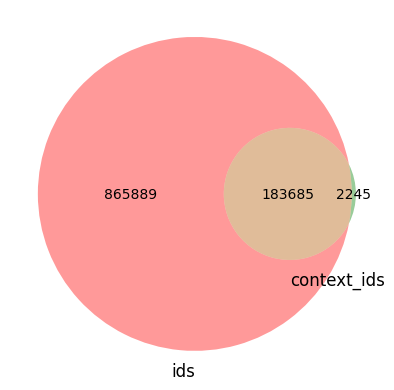

In [14]:
# Visualize the intersection of ids and context_ids
venn2([set(df_relationships['id'].tolist()), set(df_relationships['context_id'].tolist())], set_labels = ('ids', 'context_ids'))
plt.show()

In [15]:
# Create dataframe containing all ids and their text
df_all_ids = pd.concat([df_relationships[['id','text', 'created_at']], df_relationships[['context_id', 'context_text', 'context_created_at_time']].rename(columns = {'context_id':'id', 'context_text':'text', 'context_created_at_time':'created_at'})]) \
.groupby(['id','text']).min() \
.reset_index()

# Create unique identifier for text
df_all_ids['new_id'] = df_all_ids.groupby('text').ngroup().astype(str)

df_all_ids

,id,text,created_at,new_id
0,1000006497735241728,Mapping the rising tide of suicide deaths across the United States,2018-05-25 13:31:42+00:00,265601
1,1000009263463333888,"Suicide rates are on the rise, particularly in rural, red counties as a result of easy access to guns, drug abuse and abysmal socioeconomic conditions. Don't ever let the @GOP invoke ""mental health"" when statistics prove they don't really give a damn.",2018-05-25 13:42:42+00:00,311876
2,1000028737973481472,"The physician/scientist in me sees the disparity and wants to search for a helpful solution for these people, but the PJ in me is like you broke it you bought it, teabag.",2018-05-25 15:00:05+00:00,325751
3,1000031824830173184,"In other words, elections have consequences. The Republican base is getting exactly what it asked for: rage, resentment, ignorance, financial strife, a broken safety net, guns, drugs and segregation, all of which are resulting in ""untimely"" deaths. It's actual political suicide.",2018-05-25 15:12:21+00:00,246031
4,1000045525671055360,"150+ years since the Civil War and 50+ years since the Civil Rights Movement, all that Jim Crow/institutionalized racism/apartheid/MAGA has done for White America is this:",2018-05-25 16:06:47+00:00,32870
...,...,...,...,...
1051813,995548360173015041,I met @HillaryClinton earlier in the week. I thanked her. She's made things just that little bit easier for our daughters and our granddaughters. As has every strong woman across our state.,2018-05-13 06:16:40+00:00,235052
1051814,995556659966685184,"So, Sa'ad Hariri got a humiliation, from the people of Lebanon. How nice. When does he plan on resigning?",2018-05-13 06:49:38+00:00,308038
1051815,995557007544512512,"As for Nawaz Sharif he has been quite happy sending sometimes quite innocent men to the gallows through the anti-terrorism courts (ATC or military tribunals). All to appease western pressure. But those courts, no doubt, will prove useful, and Nawaz Sharif will find out why...",2018-05-13 06:51:01+00:00,180359
1051816,998966411174268928,"...population in large numbers for no reason other than to spite the bakusians (native Americans), bringing about a dust bowl in the 1930's. And the native americans took only a small proportion of the bison for meat. Such spite deserves a response & Obama's last minute...",2018-05-22 16:38:46+00:00,29187


In [16]:
# Check that there are no duplicate IDs
df_all_ids[df_all_ids['id'].duplicated(keep = False)]

,id,text,created_at,new_id


In [17]:
# Check that there are no Nan
df_all_ids.isna().sum()

id            0
text          0
created_at    0
new_id        0
dtype: int64

In [18]:
# Add new_id to df_relationships table (for both the tweet and its context)
df_relationships = df_relationships.merge(df_all_ids[['id', 'new_id']], left_on = 'id', right_on = 'id', how = 'left') \
    .merge(df_all_ids[['id', 'new_id']], left_on = 'context_id', right_on = 'id', how = 'left', suffixes=('','_context')) \
    .drop(columns = ['id_context']) \
    .rename(columns = {'new_id_context':'context_new_id'})

df_relationships

,id,text,created_at,context_id,context_type,context_text,context_created_at_time,new_id,context_new_id
0,1000009263463333888,"Suicide rates are on the rise, particularly in rural, red counties as a result of easy access to guns, drug abuse and abysmal socioeconomic conditions. Don't ever let the @GOP invoke ""mental health"" when statistics prove they don't really give a damn.",2018-05-25 13:42:42+00:00,1000006497735241728,replied_to,Mapping the rising tide of suicide deaths across the United States,2018-05-25 13:31:42+00:00,311876,265601
1,1000031824830173184,"In other words, elections have consequences. The Republican base is getting exactly what it asked for: rage, resentment, ignorance, financial strife, a broken safety net, guns, drugs and segregation, all of which are resulting in ""untimely"" deaths. It's actual political suicide.",2018-05-25 15:12:21+00:00,1000028737973481472,replied_to,"The physician/scientist in me sees the disparity and wants to search for a helpful solution for these people, but the PJ in me is like you broke it you bought it, teabag.",2018-05-25 15:00:05+00:00,246031,325751
2,1000047225395859456,"Essentially what they've done is segregated themselves into rural/suburban communities full of fearful, paranoid, politically and religiously propagandized people who are self medicating with drugs, guns and fake news then turning to violence/murder/suicide as a last resort.",2018-05-25 16:13:33+00:00,1000045525671055360,replied_to,"150+ years since the Civil War and 50+ years since the Civil Rights Movement, all that Jim Crow/institutionalized racism/apartheid/MAGA has done for White America is this:",2018-05-25 16:06:47+00:00,209464,32870
3,1000602698767482880,"My interview with #LeilaniEstates resident Victor Hoapili, whose front yard is now a massive lava lake.. #Kilauea #volcano #prayforPuna @StarAdvertiser",2018-05-27 05:00:48+00:00,NaN,NaN,NaN,NaT,275894,NaN
4,1003580907532451842,"@khamenei_ir I'm not officially posting :), but given the number of appalling comments in reply, I wanted to say that it is good to see the head of the Philosophers' republic, Ayatollah Khamanei, state the correct moral position. We can never accept the open, beastly colonialism of a people.",2018-06-04 10:15:08+00:00,NaN,NaN,NaN,NaT,138547,NaN
...,...,...,...,...,...,...,...,...,...
1073288,994272740654825472,"@anblanx @NBCInvestigates And in Novartis' statement, they're expressly trying to deflect any blame away from the new CEO (Narasimhan), that met with Trump in Davos:",2018-05-09 17:47:48+00:00,994272184821469187,replied_to,@anblanx @NBCInvestigates New Novartis CEO started the month the Cohen contract ended 2/18 (though it was announced earlier):,2018-05-09 17:45:36+00:00,116567,116568
1073289,994898467762909184,"Germans eat a variety of minced meats including pork in sausages, and name them usually with -wurst at the end: Bratwurst, Bockwurst, liverwurst... and eat them with dry bread & the strongest herb, marjoram. The human subconscious knows something... Americans place them in salad",2018-05-11 11:14:13+00:00,NaN,NaN,NaN,NaT,217959,NaN
1073290,995548360173015041,I met @HillaryClinton earlier in the week. I thanked her. She's made things just that little bit easier for our daughters and our granddaughters. As has every strong woman across our state.,2018-05-13 06:16:40+00:00,NaN,NaN,NaN,NaT,235052,NaN
1073291,995557007544512512,"As for Nawaz Sharif he has been quite happy sending sometimes quite innocent men to the gallows through the anti-terrorism courts (ATC or military tribunals). All to appease western pressure. But those courts, no doubt, will prove useful, and Nawaz Sharif will find out why...",2018-05-13 06:51:01+00:00,995556659966685184,replied_to,"So, Sa'ad Hariri got a humiliation, from the people of Lebanon. How nice. When does he plan on resigning?",2018-05-13 06:49:38+00:00,180359,308038


## df_relationships_no_duplicates

In [19]:
df_relationships_no_duplicates = df_relationships.groupby(['new_id', 'text','context_type', 'context_new_id', 'context_text'], dropna = False)[['created_at', 'context_created_at_time']].min().reset_index()

df_relationships_no_duplicates

,new_id,text,context_type,context_new_id,context_text,created_at,context_created_at_time
0,0,"Desperately need prayers for someone fighting Covid! 🙏😭 Send in positive energy and blessings, everyone! Rest, my Bajrang Bali will handle! 🙏🙏🙏",NaN,NaN,NaN,2020-10-09 16:50:17+00:00,NaT
1,1,@realDonaldTrump #BLEACH2020 A spike in New Yorkers ingesting household cleaners following Trump's controversial coronavirus comments,NaN,NaN,NaN,2020-04-25 05:06:20+00:00,NaT
2,10,"""A bath with a small amount of bleach added to the water may help lessen symptoms of chronic eczema (atopic dermatitis)."" ""Eczema is an itchy skin condition, often worsened by a bacterial infection. An eczema bleach bath can kill bacteria on the skin,",quoted,67926,@Gee_kmm @ChapwomanCZ @janep8 @CuomoPrimeTime @ChrisCuomo I like Chris but I hope his wife didn't bathe their children in Clorox.,2020-04-25 05:20:50+00:00,2020-04-25 02:38:18+00:00
3,100,#FraudAwareness Guido and Coronavirus tweets from UK authorities are top trends Only a matter of time before: Pants on fire Inject bleach and Dominic Cummings found with hand up Boris all trend,NaN,NaN,NaN,2020-04-28 19:39:09+00:00,NaT
4,1000,Misinformation about #COVID19 vaccines opens up a new battlefront in the pandemic.,quoted,326584,The rollout of COVID-19 vaccines has presented a new battle for social media websites and groups fighting online misinformation 👉,2021-03-13 16:40:12+00:00,2021-03-12 23:20:21+00:00
...,...,...,...,...,...,...,...
427856,99997,"@SAHPRA1 The potential benefits of using Ivermectin for Covid-19 was first reported more than 9 months ago. Why is a study only being done now, yet in the same time a brand new vaccine has been developed and tested?",replied_to,14889,#FlattentheCurve Please share innovative ideas on how to flatten the curve. The numbers seems to be coming down. If we pool our efforts we will overcome,2021-01-25 05:52:34+00:00,2021-01-25 04:34:32+00:00
427857,99997,"@SAHPRA1 The potential benefits of using Ivermectin for Covid-19 was first reported more than 9 months ago. Why is a study only being done now, yet in the same time a brand new vaccine has been developed and tested?",NaN,NaN,NaN,2021-01-25 07:14:49+00:00,NaT
427858,99998,@SAHPRA1 There are people dying every single day for Covid-19. Make Ivermectin available immediately as an emergency measure. People dying tonight can't wait for studies to be done. Let doctors and patients decide.,replied_to,178847,Apologies This is the link to the debate on Ivermectin,2021-01-26 15:49:10+00:00,2021-01-26 15:34:30+00:00
427859,99998,@SAHPRA1 There are people dying every single day for Covid-19. Make Ivermectin available immediately as an emergency measure. People dying tonight can't wait for studies to be done. Let doctors and patients decide.,NaN,NaN,NaN,2021-01-26 16:04:28+00:00,NaT


In [20]:
# Check only context variables have NaNs
df_relationships_no_duplicates.isna().sum()

new_id                          0
text                            0
context_type               169282
context_new_id             169397
context_text               169397
created_at                      0
context_created_at_time    169282
dtype: int64

In [21]:
# Save pandas dataframe
# pickle.dump(df_relationships, open("results/df_relationships.pkl", "wb"))
# pickle.dump(df_relationships_no_duplicates, open("results/df_relationships_no_duplicates.pkl", "wb"))
# pickle.dump(df_all_ids, open("results/df_all_ids.pkl", "wb"))

# Load pandas dataframe
df_relationships = pickle.load(open("results/df_relationships.pkl", "rb"))
df_relationships_no_duplicates = pickle.load(open("results/df_relationships_no_duplicates.pkl", "rb"))
df_all_ids = pickle.load(open("results/df_all_ids.pkl", "rb"))

# Merge tweets (remove duplicates)

## Concatenated context text

### Didactic example

Here is a dummy example of the processing that is done below to get the context text variable. 

We want to concatenate all context text in the order in which they appeared, that is, based on the time when the tweet was created.

In [122]:
# Create example data
data = {
    'new_id': [1,1, 1, 2, 2, 3],
    'text': ['Now I want coffee','Now I want coffee', 'Now I want coffee', 'Best coffee ever', 'Best coffee ever', 'New pumpkin spice latte!!!'],
    'context_type': ['quoted', 'replied_to', np.nan, np.nan, 'replied_to', np.nan],
    'context_new_id': [4, 2, np.nan, np.nan, 3, np.nan],
    'context_text': ['It\'s October, which means: Pumpkin spice latte', 'Best coffee ever', np.nan, np.nan, 'New pumpkin spice latte!!!', np.nan],
    'created_at': pd.to_datetime(['2023-10-01 06:00:00','2023-10-01 08:00:00', '2023-10-02 10:30:00', '2023-10-03 15:45:00', '2023-10-04 12:20:00', '2023-10-05 18:00:00']),
    'context_created_at_time': pd.to_datetime(['2023-10-01 06:00:00','2023-10-03 15:45:00', np.nan, np.nan, '2023-10-05 18:00:00', np.nan])
}

df_example = pd.DataFrame(data)

df_example


,new_id,text,context_type,context_new_id,context_text,created_at,context_created_at_time
0,1,Now I want coffee,quoted,4.0,"It's October, which means: Pumpkin spice latte",2023-10-01 06:00:00,2023-10-01 06:00:00
1,1,Now I want coffee,replied_to,2.0,Best coffee ever,2023-10-01 08:00:00,2023-10-03 15:45:00
2,1,Now I want coffee,NaN,NaN,NaN,2023-10-02 10:30:00,NaT
3,2,Best coffee ever,NaN,NaN,NaN,2023-10-03 15:45:00,NaT
4,2,Best coffee ever,replied_to,3.0,New pumpkin spice latte!!!,2023-10-04 12:20:00,2023-10-05 18:00:00
5,3,New pumpkin spice latte!!!,NaN,NaN,NaN,2023-10-05 18:00:00,NaT


In [124]:
# Concatenate the context text

df_concatenated_context_example = df_example \
    .groupby(["new_id", "context_new_id", "context_text"])["context_created_at_time"].min().reset_index() \
    .sort_values(['new_id', 'context_created_at_time']) \
    .groupby(['new_id'])['context_text'].apply(lambda x: '. '.join(x)).reset_index()

print(df_concatenated_context_example)

df_example.groupby(['new_id', 'text'])['created_at'].min().reset_index() \
    .merge(df_concatenated_context_example, on = 'new_id', how = "left")

   new_id                                                      context_text
0       1  It's October, which means: Pumpkin spice latte. Best coffee ever
1       2                                        New pumpkin spice latte!!!


,new_id,text,created_at,context_text
0,1,Now I want coffee,2023-10-01 06:00:00,"It's October, which means: Pumpkin spice latte. Best coffee ever"
1,2,Best coffee ever,2023-10-03 15:45:00,New pumpkin spice latte!!!
2,3,New pumpkin spice latte!!!,2023-10-05 18:00:00,NaN


### Concatenate text in our our graph of tweets

In [22]:
# Add new_id to the main dataframe
df = df.merge(df_all_ids[['id','new_id']], on = 'id', how = 'left')

In [23]:
# Concatenate context text
df_concatenated_context = df_relationships_no_duplicates \
    .groupby(["new_id", "context_new_id", "context_text"])["context_created_at_time"].min().reset_index() \
    .sort_values(['new_id', 'context_created_at_time']) \
    .groupby(['new_id'])['context_text'].apply(lambda x: '. '.join(x)).reset_index()

df_concatenated_context = df_relationships_no_duplicates.groupby(['new_id', 'text'])['created_at'].min().reset_index() \
    .merge(df_concatenated_context, on = 'new_id', how = "left")

df_concatenated_context


,new_id,text,created_at,context_text
0,0,"Desperately need prayers for someone fighting Covid! 🙏😭 Send in positive energy and blessings, everyone! Rest, my Bajrang Bali will handle! 🙏🙏🙏",2020-10-09 16:50:17+00:00,NaN
1,1,@realDonaldTrump #BLEACH2020 A spike in New Yorkers ingesting household cleaners following Trump's controversial coronavirus comments,2020-04-25 05:06:20+00:00,NaN
2,10,"""A bath with a small amount of bleach added to the water may help lessen symptoms of chronic eczema (atopic dermatitis)."" ""Eczema is an itchy skin condition, often worsened by a bacterial infection. An eczema bleach bath can kill bacteria on the skin,",2020-04-25 05:20:50+00:00,@Gee_kmm @ChapwomanCZ @janep8 @CuomoPrimeTime @ChrisCuomo I like Chris but I hope his wife didn't bathe their children in Clorox.
3,100,#FraudAwareness Guido and Coronavirus tweets from UK authorities are top trends Only a matter of time before: Pants on fire Inject bleach and Dominic Cummings found with hand up Boris all trend,2020-04-28 19:39:09+00:00,NaN
4,1000,Misinformation about #COVID19 vaccines opens up a new battlefront in the pandemic.,2021-03-13 16:40:12+00:00,The rollout of COVID-19 vaccines has presented a new battle for social media websites and groups fighting online misinformation 👉. Perspective: Every Canadian will get #COVID19 vaccine shots by September...
...,...,...,...,...
380858,99995,"@SAHPRA1 The Peru story with #Ivermectin 😉.. Take a look, another overwhelming story! Share far and wide😉",2021-02-02 04:42:10+00:00,"An update on #Ivermectin and COVID-19 from @WhiteBoardDoct1 with four outstanding experts, including our Dr. @PierreKory. #FollowtheScience. Our numbers are declining. Let us keep up the good work and beat this pandemic. Wear a mask, practice social distancing and sanitise."
380859,99996,"@SAHPRA1 The only frenzy that has been created is SAHPRA's IGNORANCE of Ivermectin, vis-a-vis blissfully ignorant acceptance of the COVID vaccine!",2021-01-18 14:40:32+00:00,"It is a matter of ""listed"" and ""registered"" - Let us all read CAREFULLY and prevent a frenzy!"
380860,99997,"@SAHPRA1 The potential benefits of using Ivermectin for Covid-19 was first reported more than 9 months ago. Why is a study only being done now, yet in the same time a brand new vaccine has been developed and tested?",2021-01-25 05:52:34+00:00,#FlattentheCurve Please share innovative ideas on how to flatten the curve. The numbers seems to be coming down. If we pool our efforts we will overcome
380861,99998,@SAHPRA1 There are people dying every single day for Covid-19. Make Ivermectin available immediately as an emergency measure. People dying tonight can't wait for studies to be done. Let doctors and patients decide.,2021-01-26 15:49:10+00:00,Apologies This is the link to the debate on Ivermectin


In [24]:
# Check that there are no new_id duplicates
print(df_concatenated_context[df_concatenated_context['new_id'].duplicated(keep = False)])

Empty DataFrame
Columns: [new_id, text, created_at, context_text]
Index: []


## Union of selected variables

For each ```new_id``` we want to get the union of all ```topics``` and ```origin_file```s. (There are tweets that exist in more than 1 file in our dataset) 

In [25]:
# group by new_id, keep all unique elements for topics and origin_file
def union_of_tuples(series):
    unique_elements = set(item for tup in series for item in tup)
    return tuple(sorted(unique_elements))

df_union_variables = df.groupby('new_id', dropna = False).agg({'origin_file': union_of_tuples, 'topics': union_of_tuples}).reset_index()
df_union_variables

,new_id,origin_file,topics
0,0,"(2013p2-tweets-1.json,)","(2013p2,)"
1,1,"(2046p1-tweets-1.json,)","(2046p1,)"
2,10,"(2046p1-tweets-1.json,)","(2046p1,)"
3,100,"(2046p1-tweets-1.json,)","(2046p1,)"
4,1000,"(2013p2-tweets-1.json, 2081p2-tweets-1.json)","(2013p2, 2081p2, 2082p2, 2083p2, 2084p2)"
...,...,...,...
380858,99995,"(2013p2-tweets-1.json,)","(2013p2,)"
380859,99996,"(2013p2-tweets-1.json,)","(2013p2,)"
380860,99997,"(2013p2-tweets-1.json,)","(2013p2,)"
380861,99998,"(2013p2-tweets-1.json,)","(2013p2, 2063p2)"


## Table without duplicates

In [26]:
# Remove duplicates for new_id, we keep the row with the oldest date
# Drop all variables related to context
# Add information from df_concatenated_context and df_union_variables
df_tweets = df.sort_values(['new_id', 'created_at']) \
    .drop(df.filter(like='context', axis=1).columns, axis=1) \
    .drop(columns=['origin_file', 'topics']) \
    .drop_duplicates(subset=['new_id']) \
    .merge(df_concatenated_context[['new_id', 'context_text']], on = 'new_id', how = 'left') \
    .merge(df_union_variables, on = 'new_id', how = 'left')

df_tweets

,id,text,created_at,user_id,username,followers,tweet_count,hashtags,cashtags,mentions,retweet_count,reply_count,like_count,quote_count,is_retweet,retweet_id,api,original_text,new_id,context_text,origin_file,topics
0,1314609136617873410,"Desperately need prayers for someone fighting Covid! 🙏😭 Send in positive energy and blessings, everyone! Rest, my Bajrang Bali will handle! 🙏🙏🙏",2020-10-09 16:50:17+00:00,22341118,veejaysai,9457,31306,(),(),(),46,21,296,1,False,NaN,v2,"नासै रोग हरै सब पीरा।\nजपत निरंतर हनुमत बीरा।।\n\nDesperately need prayers for someone fighting Covid! 🙏😭 \n\nSend in positive energy and blessings, everyone! \n\nRest, my Bajrang Bali will handle! 🙏🙏🙏 https://t.co/mKdelJWbwb",0,NaN,"(2013p2-tweets-1.json,)","(2013p2,)"
1,1253913208013889539,@realDonaldTrump #BLEACH2020 A spike in New Yorkers ingesting household cleaners following Trump's controversial coronavirus comments,2020-04-25 05:06:20+00:00,75009882,TaruniGandhi,4899,6139,"(BLEACH2020,)",(),"(realDonaldTrump,)",0,1,0,0,False,NaN,v2,हमारे यहां तो ऐसे गधों कि भरमार है। @realDonaldTrump #BLEACH2020 \n\nA spike in New Yorkers ingesting household cleaners following Trump’s controversial coronavirus comments https://t.co/8fMVWzFpfU,1,NaN,"(2046p1-tweets-1.json,)","(2046p1,)"
2,1253916860741046274,"""A bath with a small amount of bleach added to the water may help lessen symptoms of chronic eczema (atopic dermatitis)."" ""Eczema is an itchy skin condition, often worsened by a bacterial infection. An eczema bleach bath can kill bacteria on the skin,",2020-04-25 05:20:50+00:00,1738556923,ChapwomanCZ,350,43048,(),(),(),0,2,0,0,False,NaN,v2,"https://t.co/MDLQhUy7RE: ""A bath with a small amount of bleach added to the water may help lessen symptoms of chronic eczema (atopic dermatitis)."" ""Eczema is an itchy skin condition, often worsened by a bacterial infection. An eczema bleach bath can kill bacteria on the skin, https://t.co/hHvDPNHOOL",10,@Gee_kmm @ChapwomanCZ @janep8 @CuomoPrimeTime @ChrisCuomo I like Chris but I hope his wife didn't bathe their children in Clorox.,"(2046p1-tweets-1.json,)","(2046p1,)"
3,1255220023788032004,#FraudAwareness Guido and Coronavirus tweets from UK authorities are top trends Only a matter of time before: Pants on fire Inject bleach and Dominic Cummings found with hand up Boris all trend,2020-04-28 19:39:09+00:00,102955736,WillBlackWriter,100624,160448,"(FraudAwareness,)",(),(),1,0,3,0,False,NaN,v2,● #FraudAwareness \n\n● Guido \n\nand \n\n● Coronavirus tweets from UK authorities \n\nare top trends\n\nOnly a matter of time before:\n\n● Pants on fire \n\n● Inject bleach \n\nand \n\n● Dominic Cummings found with hand up Boris \n\nall trend https://t.co/PwC1K8zGON,100,NaN,"(2046p1-tweets-1.json,)","(2046p1,)"
4,1370776720240877568,Misinformation about #COVID19 vaccines opens up a new battlefront in the pandemic.,2021-03-13 16:40:12+00:00,2780260122,jessesprawl,1855,113244,"(COVID19,)",(),(),0,1,0,0,False,NaN,v2,https://t.co/SSDRtGasJp Misinformation about #COVID19 vaccines opens up a new battlefront in the pandemic. https://t.co/Yx80U9dCa7 https://t.co/DrTIzNLWtk,1000,The rollout of COVID-19 vaccines has presented a new battle for social media websites and groups fighting online misinformation 👉. Perspective: Every Canadian will get #COVID19 vaccine shots by September...,"(2013p2-tweets-1.json, 2081p2-tweets-1.json)","(2013p2, 2081p2, 2082p2, 2083p2, 2084p2)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380858,1356462893127118848,"@SAHPRA1 The Peru story with #Ivermectin 😉.. Take a look, another overwhelming story! Share far and wide😉",2021-02-02 04:42:10+00:00,786646828078989312,Dennistalksfact,602,60794,"(Ivermectin,)",(),"(SAHPRA1,)",1,0,5,0,False,NaN,v2,"@SAHPRA1 The Peru story with #Ivermectin 😉..\nTake a look, another overwhelming story! Share far and wide😉\n\nhttps://t.co/OMVXE8NyKG",99995,"An update on #Ivermectin and COVID-19 from @WhiteBoardDoct1 with four outstanding experts, inc

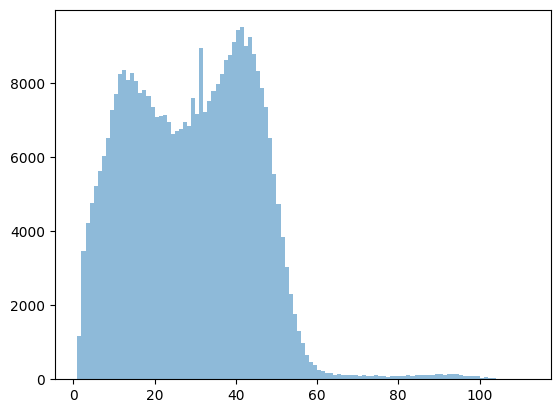

{41: 9513, 40: 9427, 43: 9254, 39: 9119, 42: 9000, 31: 8963, 44: 8800, 38: 8771, 37: 8642, 12: 8361, 45: 8327, 14: 8282, 11: 8250, 36: 8250, 13: 8100, 15: 8051, 35: 7971, 46: 7868, 17: 7815, 34: 7802, 16: 7742, 10: 7697, 18: 7657, 29: 7608, 33: 7518, 19: 7355, 47: 7346, 9: 7283, 32: 7221, 30: 7180, 22: 7147, 21: 7116, 20: 7085, 27: 6950, 23: 6949, 28: 6832, 26: 6751, 25: 6706, 24: 6626, 8: 6533, 48: 6526, 7: 6022, 6: 5624, 49: 5558, 5: 5214, 4: 4755, 50: 4749, 3: 4232, 51: 3857, 2: 3480, 52: 3030, 53: 2292, 54: 1770, 55: 1300, 1: 1159, 56: 973, 57: 654, 58: 467, 59: 381, 60: 243, 61: 212, 62: 171, 63: 166, 90: 155, 93: 147, 92: 141, 65: 139, 89: 137, 94: 135, 64: 128, 86: 125, 85: 124, 95: 124, 66: 121, 68: 120, 88: 118, 91: 118, 69: 115, 67: 114, 84: 113, 87: 113, 82: 107, 71: 105, 74: 103, 72: 102, 96: 101, 70: 100, 83: 99, 78: 96, 98: 96, 76: 95, 73: 93, 97: 92, 79: 92, 81: 86, 80: 79, 99: 79, 75: 76, 77: 62, 101: 55, 100: 44, 102: 34, 103: 31, 104: 20, 105: 10, 107: 7, 108: 4, 106:

In [27]:
# Words by tweet
text_lenght = df_tweets['text'].apply(lambda text: len(text.split()))

plt.hist(text_lenght, bins=max(text_lenght) - min(text_lenght), alpha=0.5)
plt.show()

# Most to less common lenghts
counts = collections.Counter(text_lenght)
counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
print(counts)

In [28]:
print('Percent of tweets with less than 5 words', sum(text_lenght < 5) / len(text_lenght) * 100, '%')

Percent of tweets with less than 5 words 3.5776644095120815 %


In [29]:
# Save pandas dataframe
# pickle.dump(df, open("results/df.pkl", "wb"))

# Load pandas dataframe
df = pickle.load(open("results/df.pkl", "rb"))


# Anonymize user information

In [31]:
# Table to anonymize the username
df_user = df_tweets[['user_id', 'username']].groupby(['user_id', 'username']).min().reset_index()
df_user["anonymised_user_id"] = 'user'+ df_user.groupby(['user_id', 'username']).ngroup().astype(str)

# Save pandas dataframe
pickle.dump(df_user, open("results/df_user.pkl", "wb"))
# Load pandas dataframe
df_user = pickle.load(open("results/df_user.pkl", "rb"))

df_user

,user_id,username,anonymised_user_id
0,1000006380630274049,JohnTodaro1,user0
1,1000007689915846662,Niteshadow__,user1
2,1000010821,donnap70,user2
3,1000014534814453761,LeadGamersk,user3
4,1000031914013540352,httprecious_,user4
...,...,...,...
141474,99988379,_khaadu,user141474
141475,999913699,JordanJoseph02,user141475
141476,999958937368780801,GEliseMenendez,user141476
141477,999967995102420992,VictorK43995989,user141477


In [32]:
# Add anonymized user ID and remove other user identifiers
df_tweets = df_tweets.merge(df_user, on=['user_id', 'username'], how = 'left').drop(columns = ['user_id', 'username'])

print('Total rows', len(df_tweets))
print('Columns', list(df_tweets.columns))
df_tweets

Total rows 380863
Columns ['id', 'text', 'created_at', 'followers', 'tweet_count', 'hashtags', 'cashtags', 'mentions', 'retweet_count', 'reply_count', 'like_count', 'quote_count', 'is_retweet', 'retweet_id', 'api', 'original_text', 'new_id', 'context_text', 'origin_file', 'topics', 'anonymised_user_id']


,id,text,created_at,followers,tweet_count,hashtags,cashtags,mentions,retweet_count,reply_count,like_count,quote_count,is_retweet,retweet_id,api,original_text,new_id,context_text,origin_file,topics,anonymised_user_id
0,1314609136617873410,"Desperately need prayers for someone fighting Covid! 🙏😭 Send in positive energy and blessings, everyone! Rest, my Bajrang Bali will handle! 🙏🙏🙏",2020-10-09 16:50:17+00:00,9457,31306,(),(),(),46,21,296,1,False,NaN,v2,"नासै रोग हरै सब पीरा।\nजपत निरंतर हनुमत बीरा।।\n\nDesperately need prayers for someone fighting Covid! 🙏😭 \n\nSend in positive energy and blessings, everyone! \n\nRest, my Bajrang Bali will handle! 🙏🙏🙏 https://t.co/mKdelJWbwb",0,NaN,"(2013p2-tweets-1.json,)","(2013p2,)",user62612
1,1253913208013889539,@realDonaldTrump #BLEACH2020 A spike in New Yorkers ingesting household cleaners following Trump's controversial coronavirus comments,2020-04-25 05:06:20+00:00,4899,6139,"(BLEACH2020,)",(),"(realDonaldTrump,)",0,1,0,0,False,NaN,v2,हमारे यहां तो ऐसे गधों कि भरमार है। @realDonaldTrump #BLEACH2020 \n\nA spike in New Yorkers ingesting household cleaners following Trump’s controversial coronavirus comments https://t.co/8fMVWzFpfU,1,NaN,"(2046p1-tweets-1.json,)","(2046p1,)",user118194
2,1253916860741046274,"""A bath with a small amount of bleach added to the water may help lessen symptoms of chronic eczema (atopic dermatitis)."" ""Eczema is an itchy skin condition, often worsened by a bacterial infection. An eczema bleach bath can kill bacteria on the skin,",2020-04-25 05:20:50+00:00,350,43048,(),(),(),0,2,0,0,False,NaN,v2,"https://t.co/MDLQhUy7RE: ""A bath with a small amount of bleach added to the water may help lessen symptoms of chronic eczema (atopic dermatitis)."" ""Eczema is an itchy skin condition, often worsened by a bacterial infection. An eczema bleach bath can kill bacteria on the skin, https://t.co/hHvDPNHOOL",10,@Gee_kmm @ChapwomanCZ @janep8 @CuomoPrimeTime @ChrisCuomo I like Chris but I hope his wife didn't bathe their children in Clorox.,"(2046p1-tweets-1.json,)","(2046p1,)",user51929
3,1255220023788032004,#FraudAwareness Guido and Coronavirus tweets from UK authorities are top trends Only a matter of time before: Pants on fire Inject bleach and Dominic Cummings found with hand up Boris all trend,2020-04-28 19:39:09+00:00,100624,160448,"(FraudAwareness,)",(),(),1,0,3,0,False,NaN,v2,● #FraudAwareness \n\n● Guido \n\nand \n\n● Coronavirus tweets from UK authorities \n\nare top trends\n\nOnly a matter of time before:\n\n● Pants on fire \n\n● Inject bleach \n\nand \n\n● Dominic Cummings found with hand up Boris \n\nall trend https://t.co/PwC1K8zGON,100,NaN,"(2046p1-tweets-1.json,)","(2046p1,)",user2567
4,1370776720240877568,Misinformation about #COVID19 vaccines opens up a new battlefront in the pandemic.,2021-03-13 16:40:12+00:00,1855,113244,"(COVID19,)",(),(),0,1,0,0,False,NaN,v2,https://t.co/SSDRtGasJp Misinformation about #COVID19 vaccines opens up a new battlefront in the pandemic. https://t.co/Yx80U9dCa7 https://t.co/DrTIzNLWtk,1000,The rollout of COVID-19 vaccines has presented a new battle for social media websites and groups fighting online misinformation 👉. Perspective: Every Canadian will get #COVID19 vaccine shots by September...,"(2013p2-tweets-1.json, 2081p2-tweets-1.json)","(2013p2, 2081p2, 2082p2, 2083p2, 2084p2)",user75991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380858,1356462893127118848,"@SAHPRA1 The Peru story with #Ivermectin 😉.. Take a look, another overwhelming story! Share far and wide😉",2021-02-02 04:42:10+00:00,602,60794,"(Ivermectin,)",(),"(SAHPRA1,)",1,0,5,0,False,NaN,v2,"@SAHPRA1 The Peru story with #Ivermectin 😉..\nTake a look, another overwhelming story! Share far and wide😉\n\nhttps://t.co/OMVXE8NyKG",99995,"An update on #Ivermectin and COVID-19 from @WhiteBoardDoct1 with four outstanding experts, including our Dr. @PierreKory. #FollowtheScience. Our numbers are declining. Let us keep up the good wo

# Graph of Tweets

In [56]:
# Create graph from the DataFrame
# Add nodes with edges
G = nx.from_pandas_edgelist(df=df_relationships_no_duplicates[df_relationships_no_duplicates['context_new_id'].notna()],
                            source='context_new_id',
                            target='new_id',
                            edge_attr='context_type',
                            create_using=nx.DiGraph())
# Add isolated nodes
G.add_nodes_from(set(df_relationships_no_duplicates['new_id']).union(set(df_relationships_no_duplicates['context_new_id'].dropna())))

# Save graph
pickle.dump(G, open("results/G.pkl", "wb")) #as pickle
# Save the graph directly as a GZIP compressed GraphML file (good for portability)
with gzip.open("results/G.graphml.gz", "wb") as f:
    nx.write_graphml(G, f)

In [50]:
nx.is_directed_acyclic_graph(G)

False

In [34]:
print(G.number_of_nodes())
print(G.number_of_edges())

382581
258205


In [17]:
# Possible visualization.
# It takes too long to run

# # Create an interactive network
# nt = Network(notebook=True, cdn_resources='remote')
# nt.from_nx(G)

# # Show the graph
# nt.show("graph.html")

## Components

There is one outlier in regards to the size of components.
The outlier component contains around 23% of the tweets. 

In [35]:
# Identify components
components = list(nx.connected_components(G.to_undirected()))
# Order components by size (number of tweets in them)
components = sorted(components, key=len)

# Get size of each component
components_size = [len(i) for i in components]

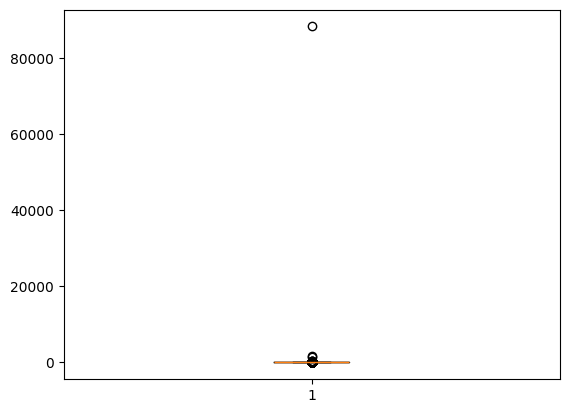

In [36]:
# Boxplot of component sizes
plt.boxplot(components_size)
plt.show()

In [37]:
# Statistics about the size of the components
print('Mean', np.mean(components_size))
print('Min', np.min(components_size))
print('Max', np.max(components_size))
print('Percentile 25', np.percentile(components_size, 25))
print('Median', np.percentile(components_size, 50))
print('Percentile 60', np.percentile(components_size, 60))
print('Percentile 75', np.percentile(components_size, 75))
print('Percentile 90', np.percentile(components_size, 90))
print('Percentile 95', np.percentile(components_size, 95))
print('Percentile 99', np.percentile(components_size, 99))
print('Percentile 99.99', np.percentile(components_size, 99.99))

# Top 20 biggeest componets
print('Size of the largest components', np.array(sorted(components_size, reverse=True))[0:20])

# Relevance of the biggest components
print(np.round(np.array(sorted(components_size, reverse=True)) / sum(components_size) * 100, 3)[0:20])


Mean 2.9735584209667265
Min 1
Max 88203
Percentile 25 1.0
Median 1.0
Percentile 60 2.0
Percentile 75 2.0
Percentile 90 4.0
Percentile 95 6.0
Percentile 99 17.0
Percentile 99.99 202.40199999997276
Size of the largest components [88203  1633  1337   419   373   316   268   255   249   246   228   218
   205   202   190   183   178   172   166   161]
[23.055  0.427  0.349  0.11   0.097  0.083  0.07   0.067  0.065  0.064
  0.06   0.057  0.054  0.053  0.05   0.048  0.047  0.045  0.043  0.042]


## Largest component 

We need to partition the largest component to later perform the train/val/test split. The partition has to remove nodes, NOT edges, of the graph.  

In [38]:
# Find the largest component
largest_component = max(components, key=len)

# Create a subgraph containing only nodes from the largest component
G_largest_component = G.subgraph(largest_component)


In [39]:
print(G_largest_component.number_of_nodes())
print(G_largest_component.number_of_edges())

88203
91451


In [148]:
# Is it acyclic?
nx.is_directed_acyclic_graph(G_largest_component)

False

In [40]:
# Get degrees of nodes in the largest component
degrees = list(G_largest_component.degree())
# Sort nodes based on their degree in descending order
degrees = sorted(degrees, key=lambda x: x[1], reverse=True)
# Top 20 nodes with more degrees
print(degrees[0:40])

[('172005', 2101), ('221024', 1772), ('359015', 1290), ('240538', 1272), ('271877', 881), ('360714', 874), ('326751', 787), ('319300', 598), ('194827', 544), ('225838', 521), ('204119', 505), ('350569', 502), ('169021', 456), ('291792', 450), ('204347', 416), ('13780', 414), ('183729', 404), ('6481', 379), ('201750', 376), ('212348', 342), ('186344', 331), ('183760', 305), ('7458', 297), ('79250', 284), ('300409', 278), ('268460', 267), ('313991', 264), ('231215', 259), ('207045', 258), ('277924', 256), ('30167', 250), ('256279', 246), ('292597', 245), ('183998', 221), ('310162', 207), ('330231', 200), ('334652', 198), ('196686', 184), ('255459', 183), ('204389', 166)]


Mean 2.0736482886069636
Min 1
Percentile 25 1.0
Median 1.0
Percentile 75 2.0
Percentile 99 2.0
Max 2101


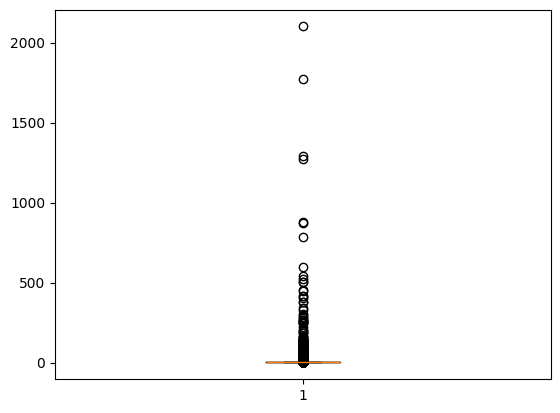

In [41]:
degrees_values = [i[1] for i in degrees]
plt.boxplot(degrees_values)
plt.show

print('Mean', np.mean(degrees_values))
print('Min', np.min(degrees_values))
print('Percentile 25', np.percentile(degrees_values, 25))
print('Median', np.percentile(degrees_values, 50))
print('Percentile 75', np.percentile(degrees_values, 75))
print('Percentile 99', np.percentile(degrees_values, 75))
print('Max', np.max(degrees_values))


> Average clustering coefficient: "The local clustering of each node in G is the fraction of triangles that actually exist over all possible triangles in its neighborhood. The average clustering coefficient of a graph G is the mean of local clusterings. "
> Rich-club coefficient: "The rich-club coefficient is designed to measure the extent to which well-connected nodes also connect to each other."

The average clustering coefficient of the largest component indicates that it doesn't contain strongly connected communities. 

In [152]:
print("Average clustering coefficient:", nx.average_clustering(G_largest_component))
print("Rich-club coefficient:", nx.rich_club_coefficient(G_largest_component.to_undirected()))

Average clustering coefficient: 0.0011837995030866996
Rich-club coefficient: {0: 1.0, 1: 0.8867668463081705, 2: 0.5784461152882205, 3: 0.250528369370834, 4: 0.1896123734962765, 5: 0.1572538316187277, 6: 0.1267799724391364, 7: 0.10840438489646773, 8: 0.09838998211091234, 9: 0.07772996234534696, 10: 0.06995768688293372, 11: 0.06264705882352942, 12: 0.05935085007727976, 13: 0.05631562201718104, 14: 0.05493050959629384, 15: 0.05003427004797807, 16: 0.04519774011299435, 17: 0.0427536231884058, 18: 0.04199182460052025, 19: 0.04122137404580152, 20: 0.04069537732121691, 21: 0.038211382113821135, 22: 0.03334722801167153, 23: 0.03421727972626176, 24: 0.0343328987396784, 25: 0.027415730337078652, 26: 0.026691210308329497, 27: 0.02737140160453044, 28: 0.023054755043227664, 29: 0.022233201581027668, 30: 0.02202202202202202, 31: 0.020376974019358125, 32: 0.020576131687242802, 33: 0.02047244094488189, 34: 0.02070063694267516, 35: 0.020507285483000542, 36: 0.02092511013215859, 37: 0.020939445387662705

All indicates that the largest component is a series of hubs, where the nodes attached to the hubs don't have much connection with anything else. 

In [42]:
# Export largest componet
nx.write_pajek(G_largest_component.to_undirected(), "G_largest_component.net")

## Partitioning the largest component

In [43]:
def identify_hubs(graph, threshold = 2):
    '''
    Identify hubs based on Z-scores
    Given a graph, returns the nodes that are considered hubs.
    '''

    graph = graph.to_undirected()

    # Get degrees of nodes
    degrees = list(graph.degree())

    # Sort nodes based on their degree in descending order
    degrees = sorted(degrees, key=lambda x: x[1], reverse=True)

    # Extract the degree values from the sorted degrees
    degrees_values = [i[1] for i in degrees]

    # Calculate Z-scores for the degree values
    z_scores = zscore(degrees_values)

    # Identify hubs based on Z-scores (considering values with Z-score > 2 as hubs)
    hubs = np.array(degrees)[z_scores > threshold][:, 0]

    return hubs

def get_n_order_neighbors(graph, node, n):
    '''
    Function to get neighbors of order <= n of a node
    '''
    graph = graph.to_undirected()
    neighbors = set([node])

    for i in range(n):
        new_neighbors = set()
        for neighbor in neighbors:
            new_neighbors.update(graph.neighbors(neighbor))
        neighbors.update(new_neighbors)

    return neighbors

### Sample example

We take a sample of the largest component to try a couple of clustering techniques and decide on which one to use. 

In [58]:
# Get the nth order neighbors of one of the hubs
n_ordered_neighbors = get_n_order_neighbors(G_largest_component, node='326751', n=3)

# generate the subgraph
G_sample = G_largest_component.subgraph(n_ordered_neighbors)

print('Number of nodes in the subgraph:', len(n_ordered_neighbors))
n_hubs = len(identify_hubs(G_sample))
print('Estimated number of hubs:', n_hubs)

Number of nodes in the subgraph: 2839
Estimated number of hubs: 4


In [380]:
# Create an interactive network
nt = Network(notebook=True, width="100%", height="800px", cdn_resources='remote')
nt.from_nx(G_sample)

# # Show the graph
nt.save_graph("results/graph_visualizations/G_sample.html")

###  Try different clustering/community detection techniques

We try different community detection techniques in a subgraph of the largest componet. 
Note that the outcome of some of the them can vary significatively depending on the seed. 
For those that use the ```resolution``` parameter, we set small values, since this favors the formation of bigger communities. 
We also try to induce having as many communities as estimated hubs. 
This is achived through the ```cutoff``` and ```k``` parameters. 

In [347]:
dict_communities = {
    'louvain1' : nx.community.louvain_communities(G_sample.to_undirected(), weight=None, seed=512, resolution = 0.1),
    'louvain2' : nx.community.louvain_communities(G_sample.to_undirected(), weight=None, seed=9384, resolution = 0.1),
    'greddy_modularity' : nx.community.greedy_modularity_communities(G_sample.to_undirected(), weight=None, resolution=0.08, cutoff=n_hubs),
    'asyn_fluidc1' : [set(community) for community in nx.community.asyn_fluidc(G_sample.to_undirected(), k = n_hubs, max_iter=1000, seed=2736)],
    'asyn_fluidc2' : [set(community) for community in nx.community.asyn_fluidc(G_sample.to_undirected(), k = n_hubs, max_iter=1000, seed=1837)]
}

In [349]:
# Order communities according to their size
for name, communities in dict_communities.items():
    dict_communities[name] = sorted(communities, key=len, reverse=True)

# Stats on communities
for name, communities in dict_communities.items():
    print(name)
    print('Number of communities', len(communities))
    print('Number of nodes in each community', [len(i) for i in communities])
    print('\n')


louvain1
Number of communities 4
Number of nodes in each community [1735, 577, 484, 43]


louvain2
Number of communities 4
Number of nodes in each community [1735, 577, 484, 43]


greddy_modularity
Number of communities 5
Number of nodes in each community [1727, 571, 518, 12, 11]


asyn_fluidc1
Number of communities 4
Number of nodes in each community [1001, 790, 590, 458]


asyn_fluidc2
Number of communities 4
Number of nodes in each community [2240, 587, 9, 3]




We break the graph by identifying pairs of nodes that share an edge with nodes outside their community. 
For each pair, we remove one of the nodes. The criteria is to remove the node with fewer degrees. 
If both have the same degrees, we remove the one that belongs to the largest community. 
If the communities of both nodes are equal in size we remove one of the nodes from the pair at random.
Note that in this process some nodes become isolated from their community. 

In [44]:
# Some functions for visualization

def rgb_to_hex(rgb):
    '''
    Transform colors from rbg to hexadecimal
    '''
    return "#{:02x}{:02x}{:02x}".format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))


def get_spaced_colors(n):
    '''
    Gets n number of colors equally spaced from the viridis color map
    '''

    # Choose a colormap from matplotlib
    colormap = colormaps['viridis']

    # Generate equally spaced values between 0 and 1
    spacing = np.linspace(0, 1, n)

    # Get corresponding colors from the colormap and convert to hexadecimal
    colors = [rgb_to_hex(colormap(x)) for x in spacing]

    return colors

def visualize_colored_communities(graph, communities, name):

    graph = graph.to_undirected()

    # Get spaced colors
    colors = get_spaced_colors(n = len(communities))

    # Create an interactive network
    nt = Network(notebook=True, width="100%", height="800px", cdn_resources='remote')

    # Add nodes and edges to the network with assigned colors
    for i, community in enumerate(communities):
        for node in community:
            if graph.has_node(node):
                nt.add_node(node, color=colors[i])

    # Add edges
    for edge in graph.edges:
        nt.add_edge(edge[0], edge[1])

    # Save graph to html
    nt.save_graph(name+'.html')

In [45]:
def disconnect_graph(graph, communities, seed_value):

    G_disconnected = nx.Graph(graph).to_undirected()

    # For reproducibility
    rng = random.Random(seed_value)

    # Stats on communities
    print('Number of communities', len(communities))
    print('Number of nodes in each community', [len(i) for i in communities])

    # Dictionary that indicates the node and its community
    communities_dict = {element: i for i, s in enumerate(communities) for element in s}

    # Get the degree of each node
    degrees = dict(G_disconnected.degree())

    # Create a list of pairs of nodes that share an edge with nodes outside their community
    pairs_in_border = []

    # Iterate through edges in the graph
    for edge in G_disconnected.edges():
        node1, node2 = edge
        community1, community2 = communities_dict[node1], communities_dict[node2]

        # Check if the edge connects nodes from different communities
        if community1 != community2:
            pairs_in_border.append((node1, node2))

    # Remove nodes based on specified criteria
    nodes_to_remove = set()
    for node1, node2 in pairs_in_border:
        deg_node1, deg_node2 = degrees[node1], degrees[node2]
        community_size_node1 = len(communities[communities_dict[node1]])
        community_size_node2 = len(communities[communities_dict[node2]])

        # Determine which node to remove based on the specified criteria
        if deg_node1 < deg_node2 or (deg_node1 == deg_node2 and community_size_node1 > community_size_node2):
            nodes_to_remove.add(node1)
        elif deg_node2 < deg_node1 or (deg_node1 == deg_node2 and community_size_node2 > community_size_node1):
            nodes_to_remove.add(node2)
        else:
            # If degrees and community sizes are equal, remove one node at random
            iteration_rng = random.Random(rng.randint(0, 2**32)) # for reproducibility
            node_to_remove = iteration_rng.choice([node1, node2])
            nodes_to_remove.add(node_to_remove)

    # Remove selected nodes
    G_disconnected.remove_nodes_from(nodes_to_remove)

    # Stats on disconnected graph
    # Identify components
    components = list(nx.connected_components(G_disconnected))
    # Order components by size (number of tweets in them)
    components = sorted(components, key=len, reverse=True)
    # Get size of each component
    components_size = [len(i) for i in components]
    print('Number of components', len(components))
    print('Number of nodes in each component', components_size)

    # Return
    return G_disconnected

In [381]:
# Generate the visualization for all community techniques
for name, communities in dict_communities.items():
    print(name)
    visualize_colored_communities(G_sample, communities, 'results/graph_visualizations/G_sample_'+name)
    G_sample_disconnected = disconnect_graph(G_sample, communities, seed_value=72)
    visualize_colored_communities(G_sample_disconnected, communities, 'results/graph_visualizations/G_sample_disconnected_'+name)
    print('\n')

louvain1
Number of communities 4
Number of nodes in each community [1735, 577, 484, 43]
Number of components 81
Number of nodes in each component [1717, 520, 405, 39, 10, 5, 5, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


louvain2
Number of communities 4
Number of nodes in each community [1735, 577, 484, 43]
Number of components 81
Number of nodes in each component [1717, 520, 405, 39, 10, 5, 5, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


greddy_modularity
Number of communities 5
Number of nodes in each community [1727, 571, 518, 12, 11]
Number of components 90
Number of nodes in each component [1707, 517, 437, 11, 10, 5, 5, 3, 3, 3,

The Fluid Communities algorithm is the most inconsistent. 
Given a different seed, the nodes number of nodes in the communities varies significantly. 
Also que communities generated, when cut, generated either the lowest or the greatest number of components. 

The Louvain method, on the other hand, generated the same communities and final components. 

Clauset-Newman-Moore greedy modularity maximization produced a couple of small communities. After prunning the graph, more components where obtained. 

Based on the previous observations, we choose to use the Louvain method for partitioning the largest component.

### Louvain method on the largest component

In [61]:
print('Estimated number of hubs:', len(identify_hubs(G_largest_component.to_undirected())))

Estimated number of hubs: 246


In [46]:
# Find communities in the largest component
communities = nx.community.louvain_communities(G_largest_component.to_undirected(), weight=None, seed=512, resolution = 0.1)
# Partition the largest graph
G_largest_component_disconnected = disconnect_graph(G_largest_component, communities, seed_value = 7193)

Number of communities 62
Number of nodes in each community [3718, 415, 1678, 271, 473, 521, 1849, 171, 2897, 204, 570, 750, 1268, 299, 3519, 951, 834, 1343, 798, 1914, 1010, 767, 2571, 239, 811, 4681, 216, 622, 1792, 599, 3628, 719, 360, 1537, 955, 1043, 5952, 1860, 671, 891, 3869, 1294, 62, 700, 180, 4142, 348, 286, 3828, 860, 91, 820, 7354, 69, 597, 1427, 931, 1664, 1333, 577, 1426, 978]
Number of components 807
Number of nodes in each component [6097, 5640, 4448, 3700, 3683, 3627, 3617, 3610, 3487, 2787, 1945, 1808, 1783, 1714, 1536, 1472, 1406, 1350, 1292, 1259, 1257, 1121, 1030, 1009, 977, 925, 854, 809, 806, 793, 741, 736, 735, 714, 694, 684, 650, 599, 596, 596, 586, 576, 570, 569, 564, 559, 518, 473, 406, 401, 374, 359, 340, 304, 299, 285, 268, 238, 234, 216, 204, 199, 188, 179, 175, 174, 173, 159, 124, 111, 103, 102, 98, 94, 93, 90, 90, 90, 90, 78, 73, 73, 72, 70, 67, 67, 66, 62, 62, 61, 61, 60, 55, 55, 53, 51, 46, 45, 44, 43, 41, 39, 38, 38, 38, 38, 37, 36, 34, 34, 33, 32, 32,

In [48]:
# Set of nodes that were removed
removed_nodes = set(G_largest_component.nodes()) - set(G_largest_component_disconnected.nodes())

# Remove nodes from the general graph
G_modified = nx.Graph(G)
G_modified.remove_nodes_from(removed_nodes)

# of components: 129467
# of nodes in each component: [6097, 5640, 4448, 3700, 3683, 3627, 3617, 3610, 3487, 2787, 1945, 1808, 1783, 1714, 1633, 1536, 1472, 1406, 1350, 1337, 1292, 1259, 1257, 1121, 1030, 1009, 977, 925, 854, 809, 806, 793, 741, 736, 735, 714, 694, 684, 650, 599, 596, 596, 586, 576, 570, 569, 564, 559, 518, 473, 419, 406, 401, 374, 373, 359, 340, 316, 304, 299, 285, 268, 268, 255, 249, 246, 238, 234, 228, 218, 216, 205, 204, 202, 199, 190, 188, 183, 179, 178, 175, 174, 173, 172, 166, 161, 161, 159, 156, 155, 147, 144, 139, 138, 135, 134, 134, 134, 130, 127, 125, 125, 124, 124, 123, 122, 121, 118, 118, 117, 116, 116, 114, 113, 113, 113, 113, 111, 108, 106, 105, 105, 105, 105, 104, 103, 102, 102, 100, 100, 99, 99, 99, 99, 98, 96, 95, 95, 95, 95, 94, 94, 94, 94, 94, 93, 93, 93, 92, 92, 90, 90, 90, 90, 90, 90, 90, 88, 87, 86, 85, 85, 84, 84, 83, 83, 83, 82, 82, 82, 81, 80, 80, 80, 80, 80, 80, 80, 80, 79, 79, 79, 78, 76, 76, 75, 74, 74, 74, 74, 74, 73, 73, 73, 73, 73, 73, 7

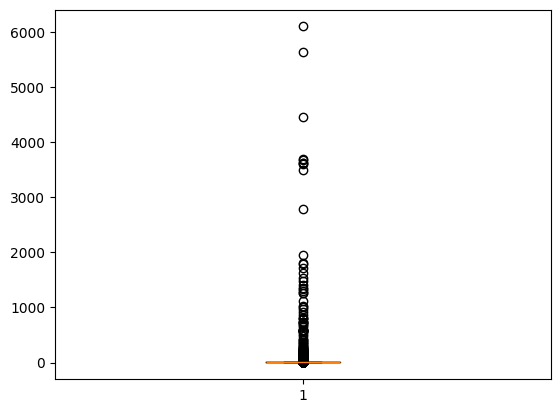

In [49]:
# Identify components
new_components = list(nx.connected_components(G_modified.to_undirected()))
# Order components by size (number of tweets in them)
new_components = sorted(new_components, key=len, reverse=True)
# Get size of each component
new_components_size = [len(i) for i in new_components]

# Stats
print('# of components:', len(new_components))
print('# of nodes in each component:', new_components_size)

# Boxplot of component sizes
plt.boxplot(new_components_size)
plt.show()

We create a component ID and add it to the datasets. 
Note that since some nodes where removed, some rows won't have a ```component_id```.

In [51]:
# Dataframe to map new_id and the component it belongs to
df_components_to_new_id = pd.DataFrame({'component_id': list(itertools.chain(*[[i] * len(j) for i, j in enumerate(new_components, start = 1)])),
                                        'new_id': list(itertools.chain(*new_components))})

# Save pandas dataframe
# pickle.dump(df_components_to_new_id, open("results/df_components_to_id.pkl", "wb"))
# Load pandas dataframe
df_components_to_new_id = pickle.load(open("results/df_components_to_id.pkl", "rb"))

df_components_to_new_id

,component_id,new_id
0,1,236652
1,1,287415
2,1,375018
3,1,169837
4,1,329001
...,...,...
382121,129463,181467
382122,129464,13049
382123,129465,83485
382124,129466,151718


In [52]:
# # Add component information to other dfs
df_tweets = df_tweets.merge(df_components_to_new_id, on = "new_id", how = 'left')

# Remove rows without component information and short tweets
minimum_words = 5
df_tweets = df_tweets[df_tweets['text'].apply(lambda text: len(text.split())) >= minimum_words]
df_tweets = df_tweets[df_tweets['component_id'].notna()]

# component_id as integer
# df_tweets['component_id'] = df_tweets['component_id'].astype('int')

# Save pandas dataframe
pickle.dump(df_tweets, open("results/df_tweets.pkl", "wb"))
# Load pandas dataframe
df_tweets = pickle.load(open("results/df_tweets.pkl", "rb"))

print('Total rows', len(df_tweets))
print('Columns', list(df_tweets.columns))

Total rows 366946
Columns ['id', 'text', 'created_at', 'followers', 'tweet_count', 'hashtags', 'cashtags', 'mentions', 'retweet_count', 'reply_count', 'like_count', 'quote_count', 'is_retweet', 'retweet_id', 'api', 'original_text', 'new_id', 'context_text', 'origin_file', 'topics', 'anonymised_user_id', 'component_id']


# Add attributes to graph

We add creation date, text and user information to the graph of tweets.
Beware this is a time consuming process (it takes arround 10h). 

First, we extract key information like the text of the tweet and the creation date from ```df_all_ids``` and the anonymised user id from ```df_tweets```. 
We use this information to insert it on $G$.
Then, we create a subgraph of $G$ that does not includes the nodes that were removed in the process to break the largest component.   

In [58]:
df_all_ids = pickle.load(open("results/df_all_ids.pkl", "rb"))

# Table with tweet new_id, text, posted datetime and user.
df_basic_info = df_all_ids[['new_id', 'text', 'created_at']].groupby(['text', 'new_id']).min().reset_index()
print('Number of rows before merge', len(df_basic_info))
df_basic_info = df_basic_info.merge(df_tweets[['new_id', 'anonymised_user_id']], on = "new_id", how = 'left')
print('Number of rows after merge', len(df_basic_info))

# fill nas in anonymised_user_id
df_basic_info['anonymised_user_id'] = df_basic_info['anonymised_user_id'].fillna(value='userunknown')

Number of rows before merge 382581
Number of rows after merge 382581


In [19]:
# # This process took around 7 hours to run, uncomment if you are sure you need to run it again

# # Add text and datetime information to the graph

# # Iterate over dataset and update the node attributes
# G_with_attributes = nx.Graph(G)
# for index, row in tqdm(df_basic_info.iterrows()):
#     id = row['new_id']
#     if id in set(G_with_attributes.nodes):
#         G_with_attributes.nodes[id]['created_at'] = row['created_at']
#         G_with_attributes.nodes[id]['text'] = row['text']
#         G_with_attributes.nodes[id]['anonymised_user_id'] = row['anonymised_user_id']

# pickle.dump(G_with_attributes, open("results/G_with_attributes.pkl", "wb"))

G_with_attributes = pickle.load(open("results/G_with_attributes.pkl", "rb"))

In [20]:
# Convert pandas.Timestamp to Unix time (integer). This is necessary to save the graph as a graphml file
def convert_timestamp_to_unix(graph):
    for node, data in graph.nodes(data=True):
        for attr, value in data.items():
            if isinstance(value, pd.Timestamp):
                data[attr] = value.timestamp()  # Convert to Unix time

    for u, v, data in graph.edges(data=True):
        for attr, value in data.items():
            if isinstance(value, pd.Timestamp):
                data[attr] = value.timestamp()  # Convert to Unix time

# Apply the conversion to the graph G
convert_timestamp_to_unix(G_with_attributes)

# Save the graph directly as a GZIP compressed GraphML file (good for portability)
with gzip.open("results/G_with_attributes.graphml.gz", "wb") as f:
    nx.write_graphml(G_with_attributes, f)

In [18]:
# Graph with attributes, without the removed nodes
G_modified_with_attributes = nx.Graph(G_with_attributes)
G_modified_with_attributes.remove_nodes_from(removed_nodes)
pickle.dump(G_modified_with_attributes, open("results/G_modified_with_attributes.pkl", "wb"))

# Convert pandas.Timestamp to Unix time (integer). This is necessary to save the graph as a graphml file
convert_timestamp_to_unix(G_modified_with_attributes)
# Save the graph directly as a GZIP compressed GraphML file (good for portability)
with gzip.open("results/G_modified_with_attributes.graphml.gz", "wb") as f:
    nx.write_graphml(G_modified_with_attributes, f)

In [3]:
print('Number of nodes:', G_modified_with_attributes.number_of_nodes())
print('Number of arcs:', G_modified_with_attributes.number_of_edges())

Number of nodes: 382126
Number of arcs: 256269


In [66]:
# Check that all nodes have attributes
count = 0
for node in G_modified_with_attributes.nodes():
    if 'created_at' not in G_modified_with_attributes.nodes[node] or 'text' not in G_modified_with_attributes.nodes[node]:
        print(f"Node {node} is missing attributes.")
        count += 1
print(count, 'nodes without attributes')

0 nodes without attributes


# Anex

## Example of tweet

In the following tweet it looks like the data cleaning process didn't identified part of the link, but actually the numbers where not part of the original link. 

https://twitter.com/zin_zah/status/1295072862886387712

![](img/tweet_example.png)

In [137]:
print('original text', list(df[df['new_id'] == 186]['original_text']))
print('clean text ', list(df[df['new_id'] == 186]['text']))

original text ['https://t.co/Y1zEwGxoH9\n836/x 🏫🇮🇱\n\nThis school reopened and 1 child infected 25 teachers\nDuring the first few months of the pandemic, Israel was praised for its response to the coronavirus but after the country reopened its schools, it has seen a surge in outbreaks.']
clean text  [' 836/x 🏫🇮🇱 This school reopened and 1 child infected 25 teachers During the first few months of the pandemic, Israel was praised for its response to the coronavirus but after the country reopened its schools, it has seen a surge in outbreaks.']


In [195]:
df_tweets[df_tweets['new_id'] == '38473']

,id,text,created_at,user_id,username,followers,tweet_count,hashtags,cashtags,mentions,retweet_count,reply_count,like_count,quote_count,is_retweet,retweet_id,api,original_text,new_id,context_text,origin_file,topics,component_id
312777,1366628657519861761,"9) Suppose Pfizer prevented 9 cases... 10 cases in placebo, 1 in vaccine90% efficacy. But if J&J was carried out when rates are high, then could be 20 cases in placebo, and 11 in J&J vaccinatedThe efficacy is then 45%! (This is what happens it yields absolute risk decrease)",2021-03-02 05:57:17+00:00,18831926,DrEricDing,573166,54064,(),(),(),77,6,327,2,False,NaN,v2,"9) Suppose Pfizer prevented 9 cases... 10 cases in placebo, 1 in vaccine—90% efficacy. \n\nBut if J&amp;J was carried out when rates are high, then could be 20 cases in placebo, and 11 in J&amp;J vaccinated—The efficacy is then 45%!\n\n(This is what happens it yields absolute risk decrease)",38473,"8) Furthermore, the J&J trial was done in a middle of the WORST SURGE periods in each country that implemented the J&J trial! What does this matter? In epidemiology, we call this high background ratewhich can skew efficacy vs the Pfizer/Moderna trials with low rateshere is how:","(2081p2-tweets-1.json,)","(2080p2, 2081p2, 2085p2)",45
